# Practical Machine Learning for Physicists
## Week 6 Exercise
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [54]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [55]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)


In [56]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


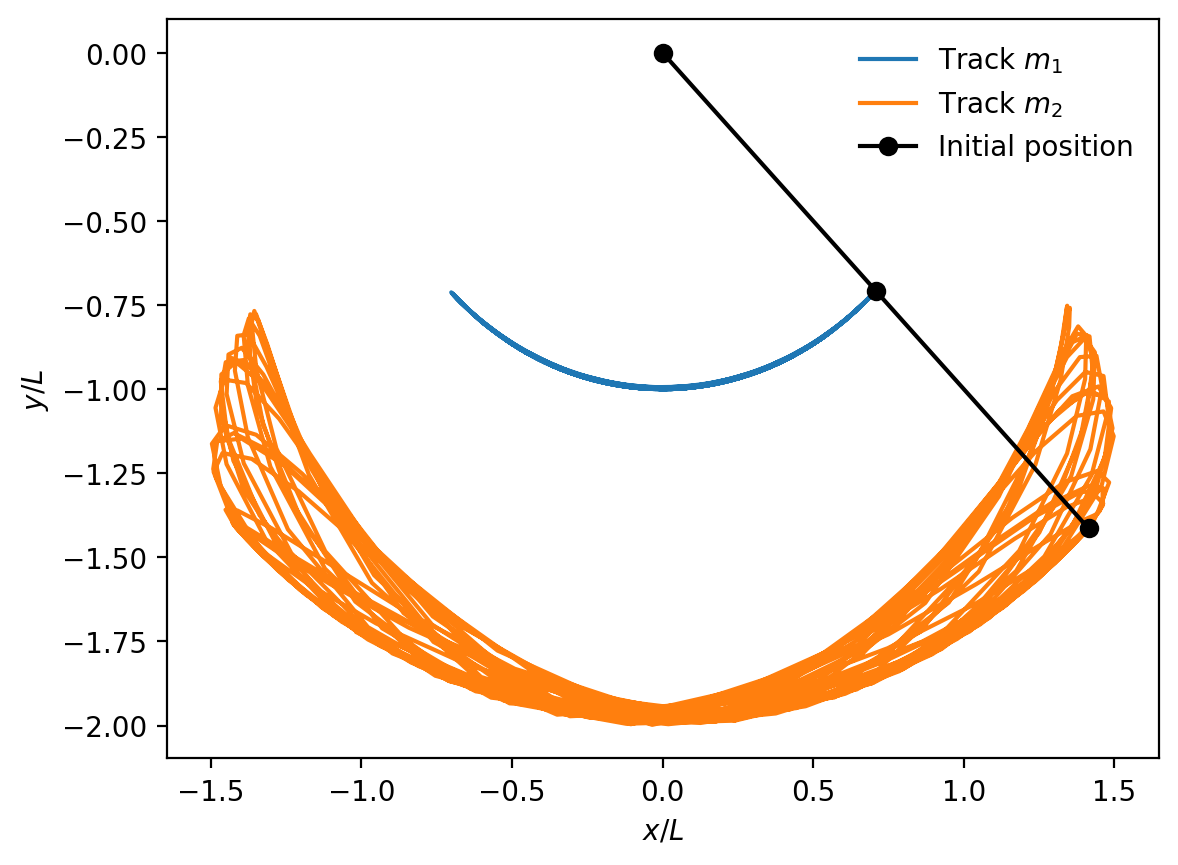

In [57]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# Task 1
Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as t=$t_0$ + 20 $\delta$t, of the masses $m_1$ and $m_2$ using their cartesian coordiantes and the initial conditions $z_0 = [ π/4,0,π/4,0]$.


In [177]:
#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Define
model=keras.models.Sequential()
model.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=False))
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, None, 50)          11000     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_11 (Dense)            (None, 4)                 204       
                                                                 
Total params: 31404 (122.67 KB)
Trainable params: 31404 (122.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [178]:
def shapeArray2D(x, window_size, offset):
    """
    Split up a 2-d array x into a series of overlapping windows and corresponding labels.
    """
    dimentionality_of_x = x.shape[0]
    Number_of_Windows = x.shape[1] - window_size - offset + 1
    x_input = np.zeros((Number_of_Windows, window_size, dimentionality_of_x))
    x_label = np.zeros((Number_of_Windows, dimentionality_of_x))

    for i in range(dimentionality_of_x):
        x_input[i] = x[:, i:i+window_size].T
        x_label[i] = x[:, i+window_size+offset-1]

    return x_input, x_label

In [179]:
# test of the function
s=np.random.randint(5,size=(4,20))
x_input_s,x_label_s = shapeArray2D(s,10,5)
print(x_input_s.shape)
# note we will get a shape of (Number of window, Window Size, 4)

(6, 10, 4)


In [180]:
from pathlib import WindowsPath
# we have previously worked out the cartesian solution
print("Shape of x1,y1,x2,y2 is",x1.shape, y1.shape,x2.shape,y2.shape)

# note that target = (Window size + offset - 1) and our target is 20
Windowsize=10
offset=11

# Training data
print()

x1_train =x1[0:int(0.9*len(x1))]
y1_train = y1[0:int(0.9*len(y1))]
x2_train = x2[0:int(0.9*len(x2))]
y2_train = y2[0:int(0.9*len(y2))]



z_train=np.column_stack((x1_train,y1_train,x2_train,y2_train)).T


# shape array into window size and offset target
train_data, train_label = shapeArray2D(z_train,Windowsize,offset)


# Train the recurrent neural network using these cartesian solution to predict the 20th time step t=t_0 + 20 dt
steps=600


#storage for training parameters
train_cost=np.zeros(steps)




Shape of x1,y1,x2,y2 is (501,) (501,) (501,) (501,)



In [182]:
# define a function to train the recurrent neural network
def train_model(model, train_d,train_l,step,windowsize):

    train_cost=np.zeros(step)


    for j in tqdm(range(step)):

        # training our train_data
        train_data=train_d.reshape(train_d.shape[0],windowsize,4)
        train_label=train_l.reshape(train_l.shape[0],4)
        train_cost[j]=model.train_on_batch(train_data,train_label)



    # Prediction
    train_data_parameter = train_d.reshape(train_d.shape[0],windowsize,4)


    train_pre = model.predict_on_batch(train_data_parameter)


    return train_cost, train_pre


In [184]:
Cost, train_predict = train_model(model, train_data, train_label,steps,Windowsize)

100%|██████████| 600/600 [00:41<00:00, 14.34it/s]


In [185]:
#Because we have set the window size and offset, the row element of train_predict is the 20th timestep


x1_p, y1_p, x2_p, y2_p= train_predict[0,:]
print("The future position of mass m1 is", (x1_p,y1_p))
print("The future position of mass m2 is", (x2_p,y2_p))

# we can compare this to the original solution via solve_ivp
print("Data position for mass m1 is",(x1[20],y1[20]))
print("Data position for mass m2 is",(x2[20],y2[20]))



The future position of mass m1 is (0.035319693, -1.0004053)
The future position of mass m2 is (0.3325407, -1.9604828)
Data position for mass m1 is (0.0345482576826827, -0.9994030307594084)
Data position for mass m2 is (0.32885641537207594, -1.955113608454076)


## Comment on result for Task 1
We have trained the recurrent neural network to predict the future position (20th timestep) which seems to be quite accurate (to 1dp).

## Task 2
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

In [204]:
model2=keras.models.Sequential()

model2.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=True)) # LSTM layer with 50 neurons
model2.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=False))
model2.add(keras.layers.Dense(4,activation='linear'))

model2.compile(loss='mean_squared_error',optimizer='adam')

model2.summary()
# Train Array
x1_train = x1[0:int(1*len(x1))]
y1_train = y1[0:int(1*len(y1))]
x2_train = x2[0:int(1*len(x2))]
y2_train = y2[0:int(1*len(y2))]

# Create Data Storage for Train data and Test data

z_train = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

def shapearray(dataset, windowsize, offset):

    data,label=[],[]
    #loop over entire dataset
    for i in range(windowsize,len(dataset[0])-offset):
        #extract an item(input) of size (windowsize) of elements from i-windowsize to i
        item=dataset[:,(i-windowsize):i]

        #append item to corresponding lists
        data.append(item)
        label.append(dataset[:,i+offset])
    #turn lists into arrays
    data, label = np.array(data), np.array(label)
    return data, label

# Parameters
steps = 1000
windowsize = 30
offset = 20

# Data
train_data, train_label = shapearray(z_train, windowsize, offset)


def train_cost_pred_model(model, train_data, train_label, steps, windowsize):
    # Storage of training and testing data
    train_cost = np.zeros(steps)


    for i in tqdm(range(steps)):
        # Reshape input and labels for training data
        train_data_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])
        train_label_reshaped = train_label.reshape(train_label.shape[0], train_label.shape[1])
        train_cost[i] = model.train_on_batch(train_data_reshaped, train_label_reshaped)



    # Reshape input for prediction
    train_input_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])

    train_predict = model2.predict_on_batch(train_input_reshaped)


    return train_cost, train_predict

train_cost1 , train_predicted = train_cost_pred_model(model2,train_data,train_label,steps,windowsize)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, None, 50)          11000     
                                                                 
 lstm_25 (LSTM)              (None, 50)                20200     
                                                                 
 dense_20 (Dense)            (None, 4)                 204       
                                                                 
Total params: 31404 (122.67 KB)
Trainable params: 31404 (122.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


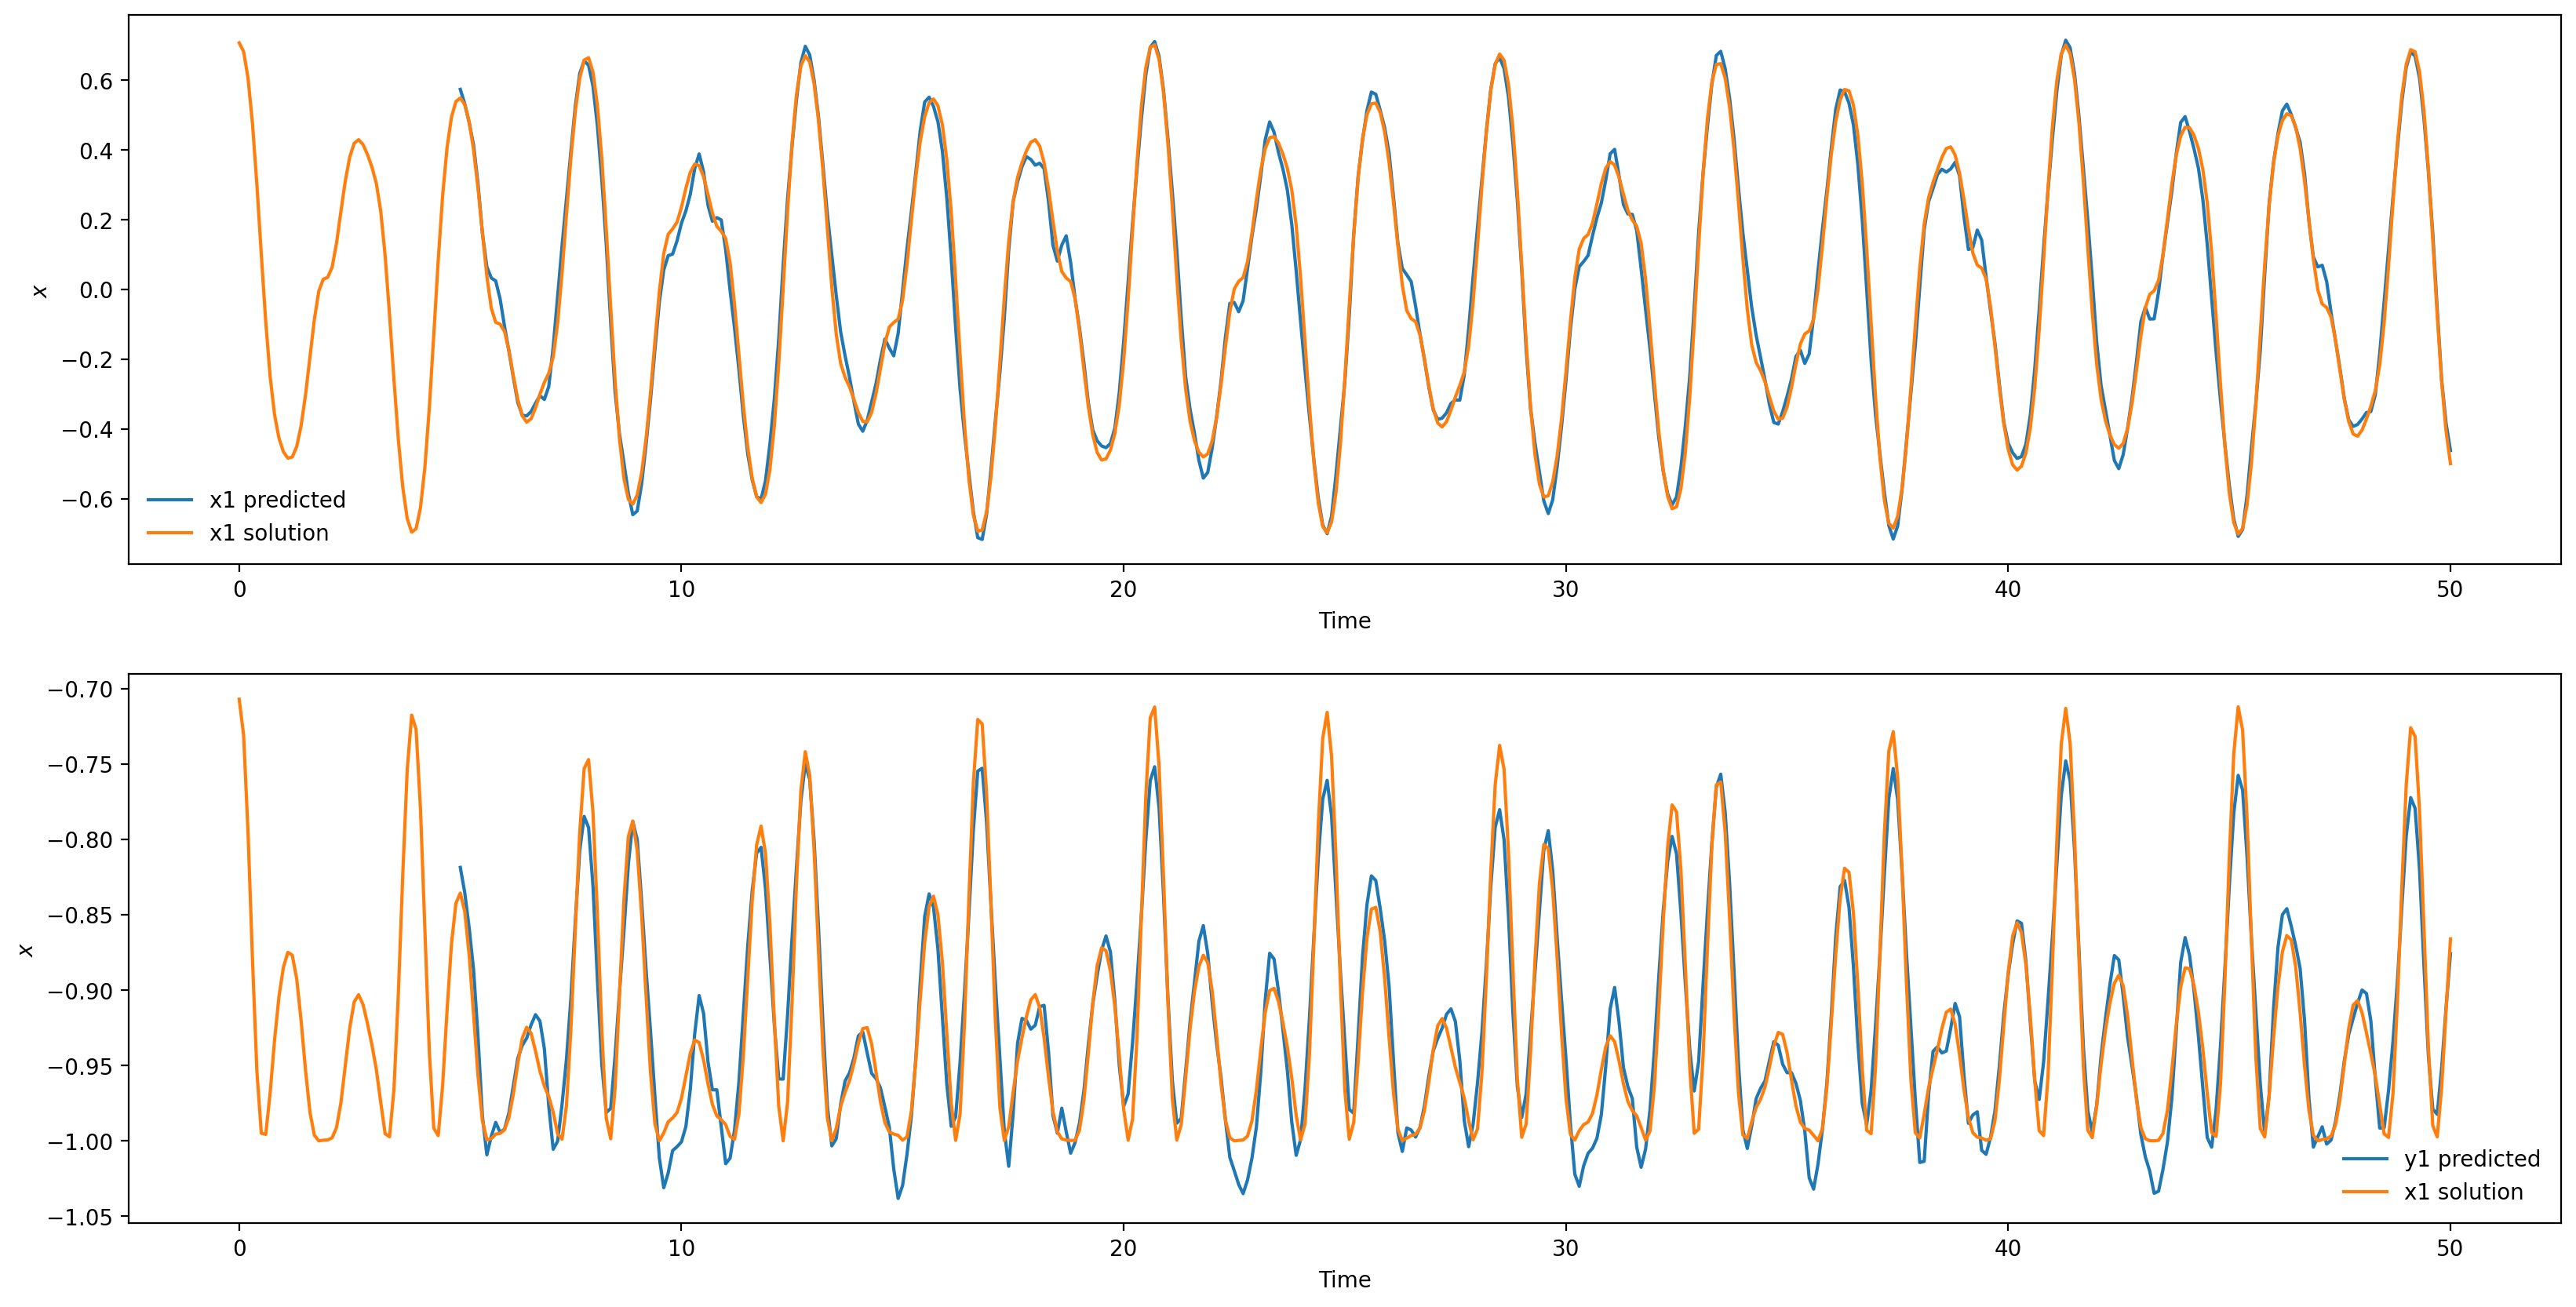

In [216]:
# mass 1
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(t[50:],train_predicted[:,0],label='x1 predicted')
ax[0].plot(t,x1,label='x1 solution')
ax[0].set_ylabel(r"$  x $")
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(t[50:],train_predicted[:,1],label='y1 predicted')
ax[1].plot(t,y1,label='x1 solution')
ax[1].set_ylabel(r"$  x $")
ax[1].set_xlabel("Time")
ax[1].legend()

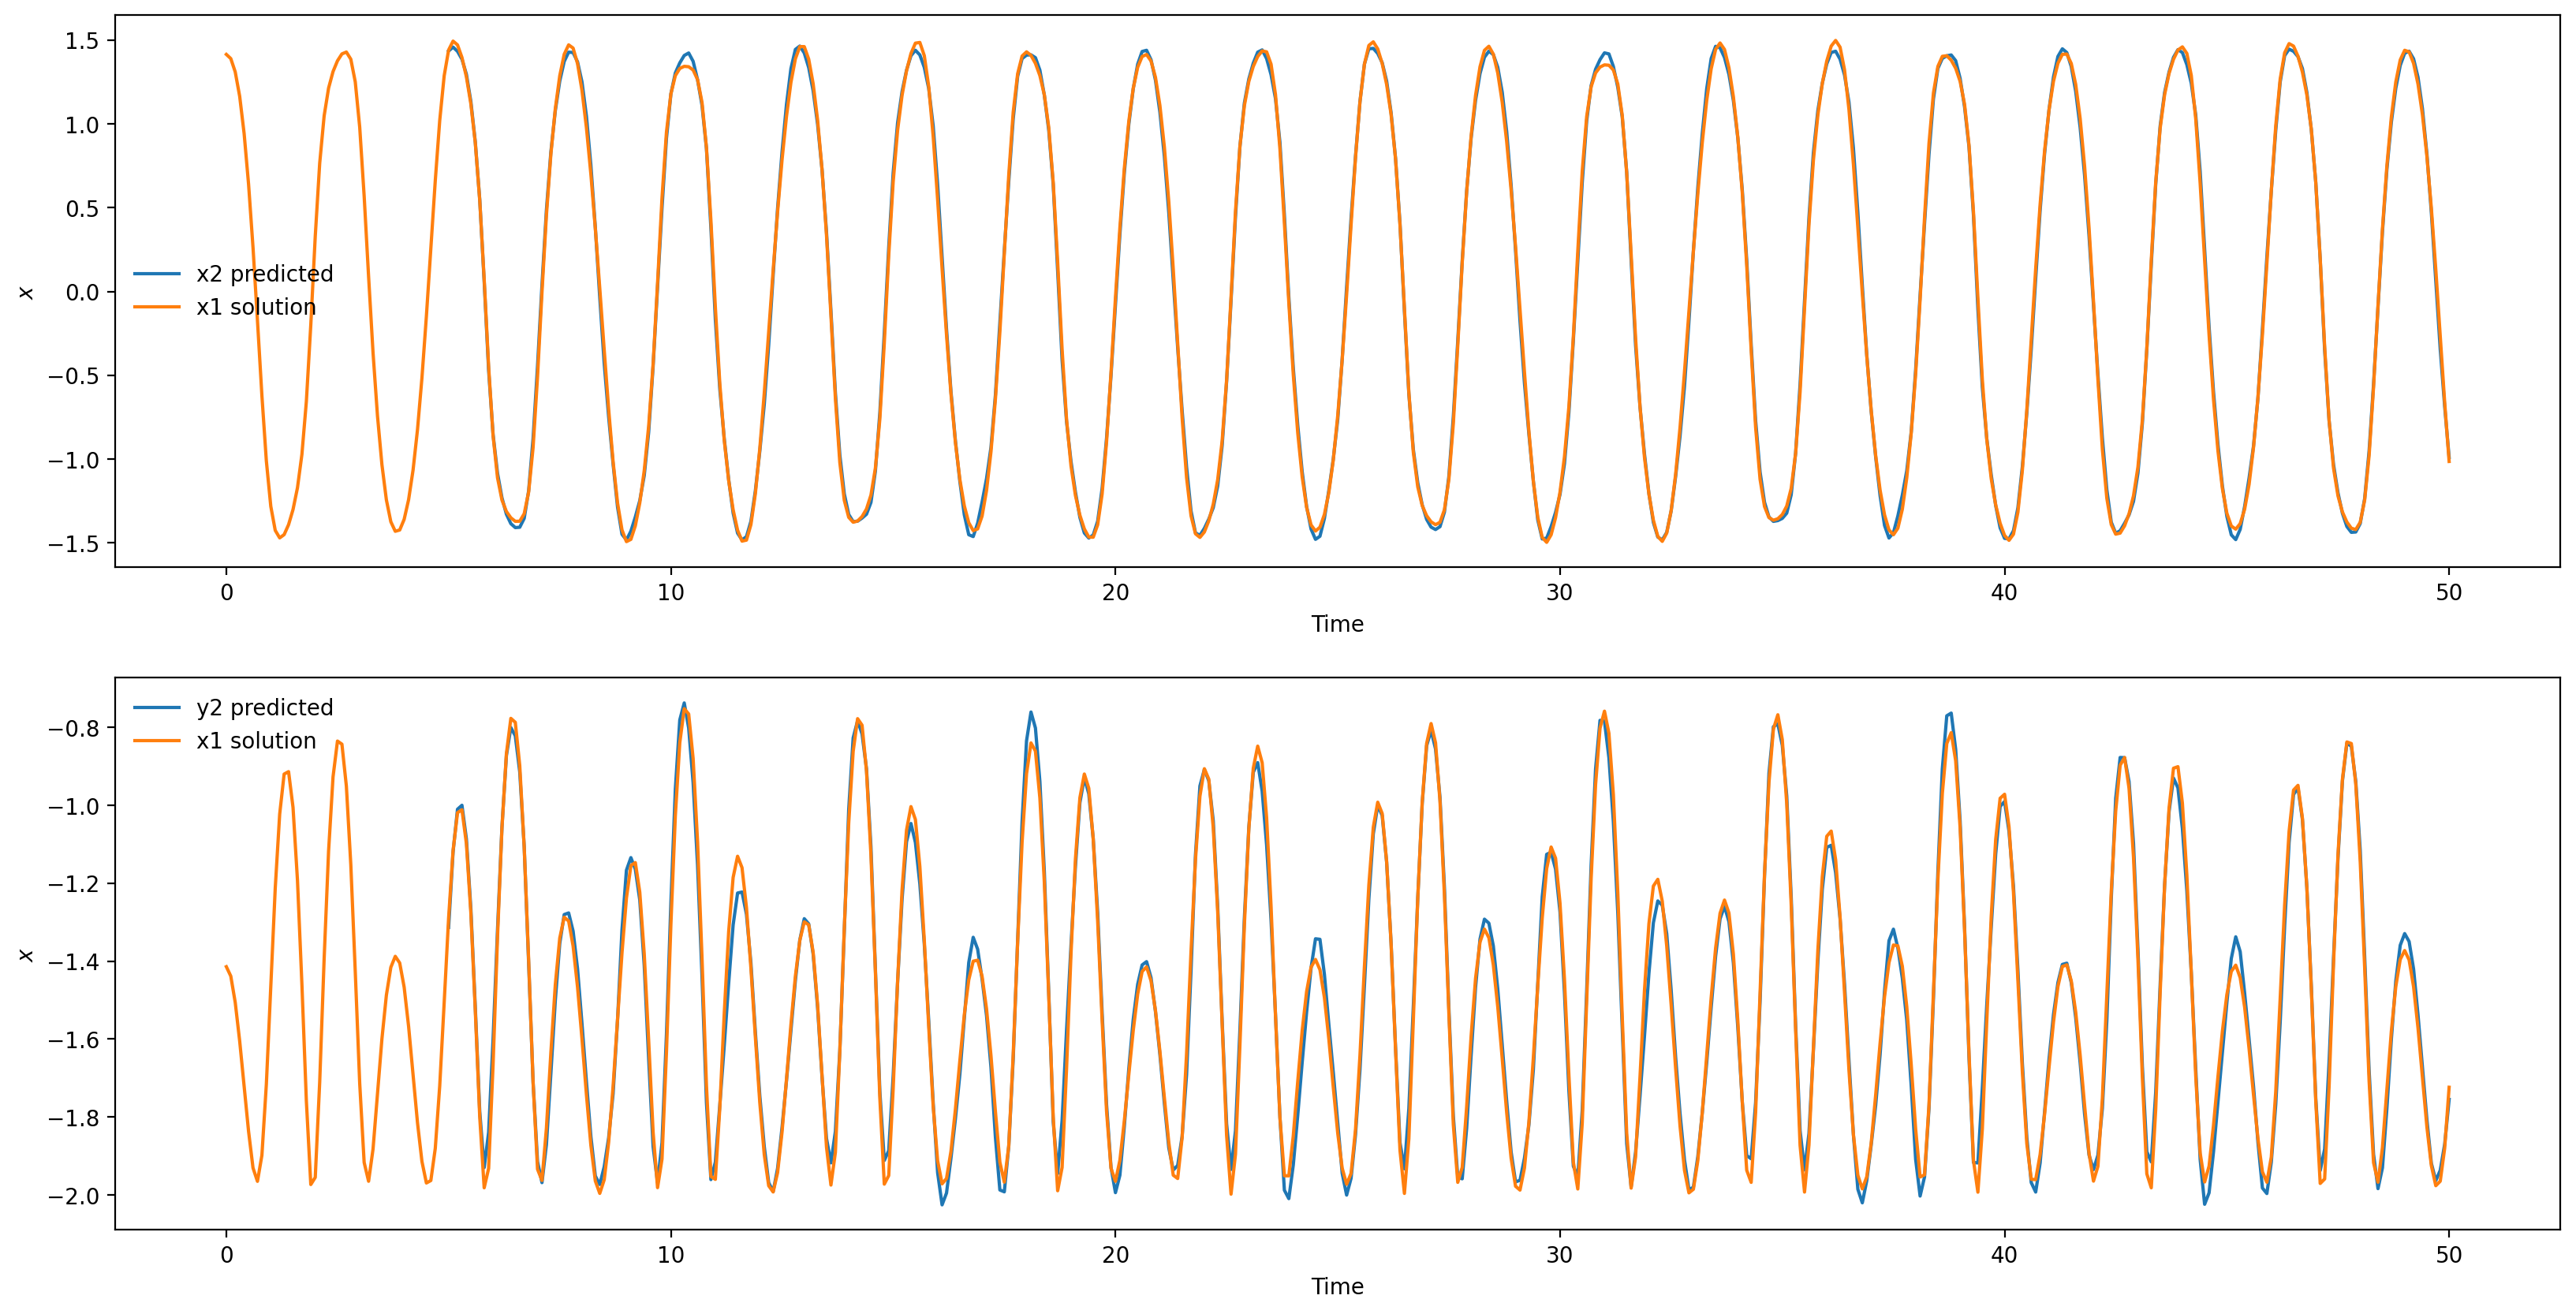

In [217]:
# mass 1
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(t[50:],train_predicted[:,2],label='x2 predicted')
ax[0].plot(t,x2,label='x1 solution')
ax[0].set_ylabel(r"$  x $")
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(t[50:],train_predicted[:,3],label='y2 predicted')
ax[1].plot(t,y2,label='x1 solution')
ax[1].set_ylabel(r"$  x $")
ax[1].set_xlabel("Time")
ax[1].legend()

## Task 3
How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

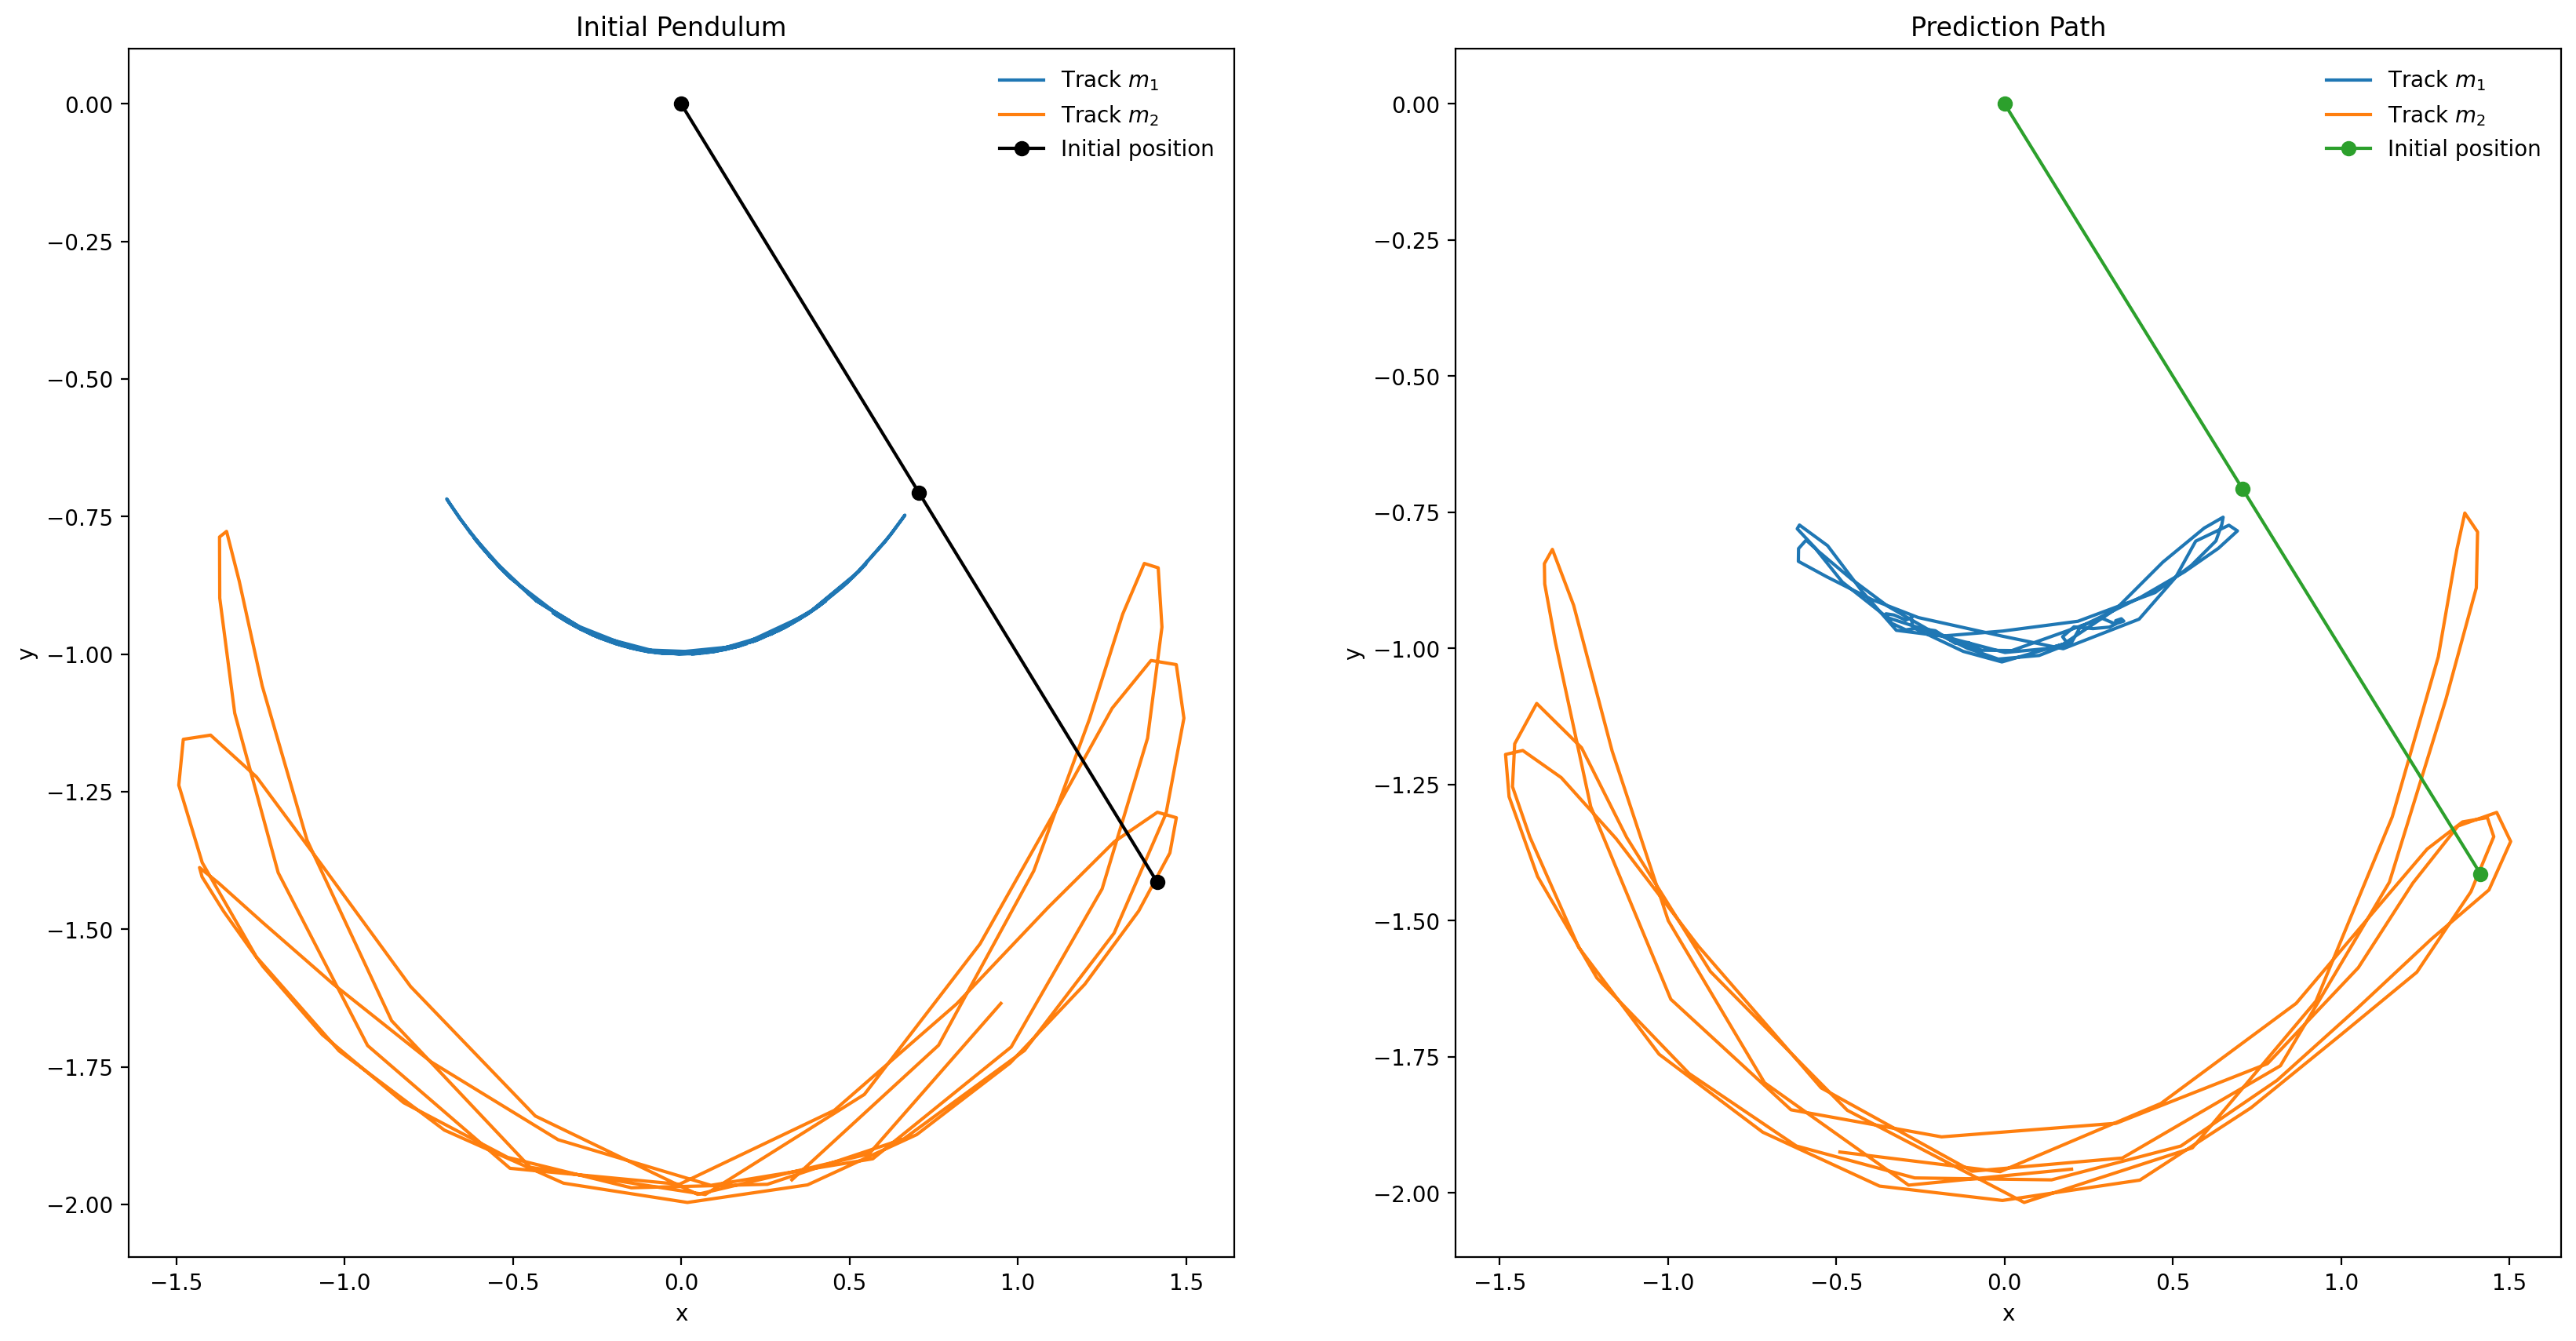

In [200]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
# Plot of original solution solve.ivp
ax[0].plot(x1[20:100], y1[20:100], label=r"Track $m_1$")
ax[0].plot(x2[20:100], y2[20:100], label=r"Track $m_2$")
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].set_title("Initial Pendulum")
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

# plot of predicted path
ax[1].plot(train_predicted[:,0][20:100], train_predicted[:,1][20:100], label=r"Track $m_1$")
ax[1].plot(train_predicted[:,2][20:100], train_predicted[:,3][20:100], label=r"Track $m_2$")
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position")
ax[1].set_title("Prediction Path")
ax[1].set_ylabel("y")
ax[1].set_xlabel("x")
ax[1].legend()


## Task 4
Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.

# Task 4 repeat task 1

In [218]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/2,0,np.pi/2,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


In [221]:
#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Define
model=keras.models.Sequential()
model.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=False))
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()
def shapeArray2D(x, window_size, offset):
    """
    Split up a 2-d array x into a series of overlapping windows and corresponding labels.
    """
    dimentionality_of_x = x.shape[0]
    Number_of_Windows = x.shape[1] - window_size - offset + 1
    x_input = np.zeros((Number_of_Windows, window_size, dimentionality_of_x))
    x_label = np.zeros((Number_of_Windows, dimentionality_of_x))

    for i in range(dimentionality_of_x):
        x_input[i] = x[:, i:i+window_size].T
        x_label[i] = x[:, i+window_size+offset-1]

    return x_input, x_label

from pathlib import WindowsPath
# we have previously worked out the cartesian solution
print("Shape of x1,y1,x2,y2 is",x1.shape, y1.shape,x2.shape,y2.shape)

# note that target = (Window size + offset - 1) and our target is 20
Windowsize=10
offset=11

# Training data
print()

x1_train =x1[0:int(0.9*len(x1))]
y1_train = y1[0:int(0.9*len(y1))]
x2_train = x2[0:int(0.9*len(x2))]
y2_train = y2[0:int(0.9*len(y2))]



z_train=np.column_stack((x1_train,y1_train,x2_train,y2_train)).T


# shape array into window size and offset target
train_data, train_label = shapeArray2D(z_train,Windowsize,offset)


# Train the recurrent neural network using these cartesian solution to predict the 20th time step t=t_0 + 20 dt
steps=600


#storage for training parameters
train_cost=np.zeros(steps)

# define a function to train the recurrent neural network
def train_model(model, train_d,train_l,step,windowsize):

    train_cost=np.zeros(step)


    for j in tqdm(range(step)):

        # training our train_data
        train_data=train_d.reshape(train_d.shape[0],windowsize,4)
        train_label=train_l.reshape(train_l.shape[0],4)
        train_cost[j]=model.train_on_batch(train_data,train_label)



    # Prediction
    train_data_parameter = train_d.reshape(train_d.shape[0],windowsize,4)


    train_pre = model.predict_on_batch(train_data_parameter)


    return train_cost, train_pre

Cost, train_predict = train_model(model, train_data, train_label,steps,Windowsize)

#Because we have set the window size and offset, the row element of train_predict is the 20th timestep


x1_p, y1_p, x2_p, y2_p= train_predict[0,:]
print("The future position of mass m1 is", (x1_p,y1_p))
print("The future position of mass m2 is", (x2_p,y2_p))

# we can compare this to the original solution via solve_ivp
print("Data position for mass m1 is",(x1[20],y1[20]))
print("Data position for mass m2 is",(x2[20],y2[20]))



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, None, 50)          11000     
                                                                 
 lstm_27 (LSTM)              (None, 50)                20200     
                                                                 
 dense_21 (Dense)            (None, 4)                 204       
                                                                 
Total params: 31404 (122.67 KB)
Trainable params: 31404 (122.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of x1,y1,x2,y2 is (501,) (501,) (501,) (501,)



100%|██████████| 600/600 [00:46<00:00, 12.82it/s]


The future position of mass m1 is (0.27781424, -0.96344805)
The future position of mass m2 is (0.13885854, 0.028872533)
Data position for mass m1 is (0.27614862326089656, -0.9611149451918388)
Data position for mass m2 is (0.13710703120212095, 0.029171597015900663)


## Comment on the accuracy
The accuracy is up to 2d.p

# Task 4 repeat task 2

In [222]:
model2=keras.models.Sequential()

model2.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=True)) # LSTM layer with 50 neurons
model2.add(keras.layers.LSTM(50,input_shape=(None,4),return_sequences=False))
model2.add(keras.layers.Dense(4,activation='linear'))

model2.compile(loss='mean_squared_error',optimizer='adam')

model2.summary()
# Train Array
x1_train = x1[0:int(1*len(x1))]
y1_train = y1[0:int(1*len(y1))]
x2_train = x2[0:int(1*len(x2))]
y2_train = y2[0:int(1*len(y2))]

# Create Data Storage for Train data and Test data

z_train = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

def shapearray(dataset, windowsize, offset):

    data,label=[],[]
    #loop over entire dataset
    for i in range(windowsize,len(dataset[0])-offset):
        #extract an item(input) of size (windowsize) of elements from i-windowsize to i
        item=dataset[:,(i-windowsize):i]

        #append item to corresponding lists
        data.append(item)
        label.append(dataset[:,i+offset])
    #turn lists into arrays
    data, label = np.array(data), np.array(label)
    return data, label

# Parameters
steps = 1000
windowsize = 30
offset = 20

# Data
train_data, train_label = shapearray(z_train, windowsize, offset)


def train_cost_pred_model(model, train_data, train_label, steps, windowsize):
    # Storage of training and testing data
    train_cost = np.zeros(steps)


    for i in tqdm(range(steps)):
        # Reshape input and labels for training data
        train_data_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])
        train_label_reshaped = train_label.reshape(train_label.shape[0], train_label.shape[1])
        train_cost[i] = model.train_on_batch(train_data_reshaped, train_label_reshaped)



    # Reshape input for prediction
    train_input_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])

    train_predict = model2.predict_on_batch(train_input_reshaped)


    return train_cost, train_predict

train_cost1 , train_predicted = train_cost_pred_model(model2,train_data,train_label,steps,windowsize)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, None, 50)          11000     
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dense_22 (Dense)            (None, 4)                 204       
                                                                 
Total params: 31404 (122.67 KB)
Trainable params: 31404 (122.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 1000/1000 [02:57<00:00,  5.63it/s]


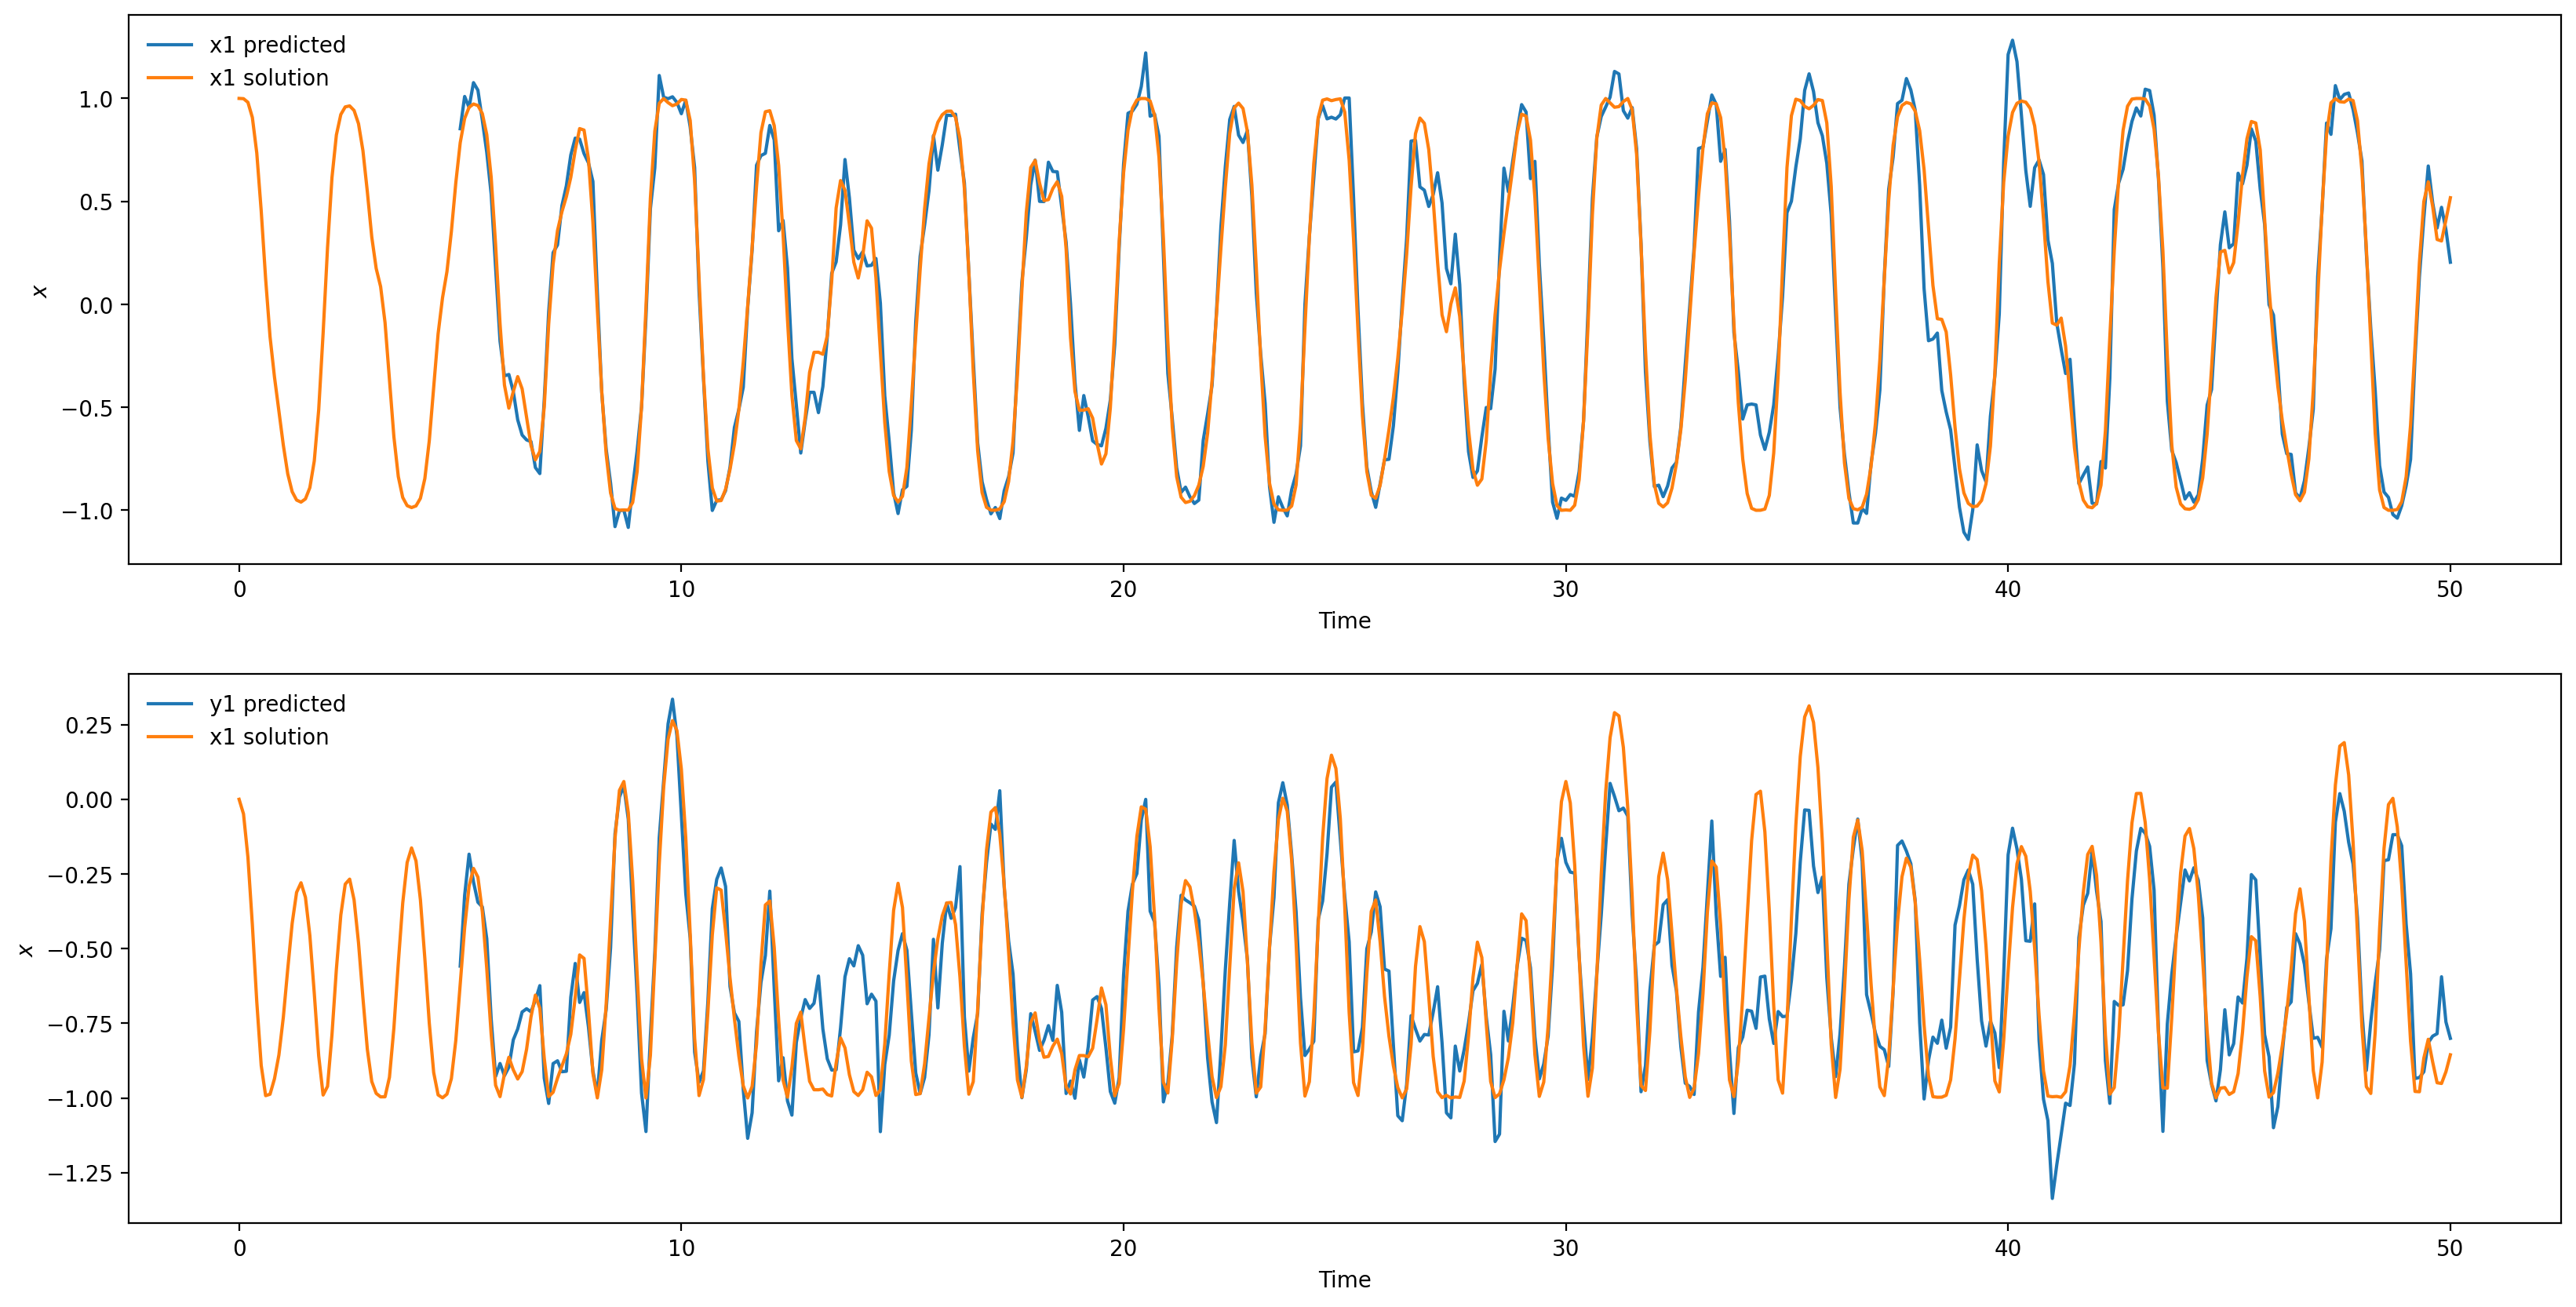

In [223]:
# mass 1
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(t[50:],train_predicted[:,0],label='x1 predicted')
ax[0].plot(t,x1,label='x1 solution')
ax[0].set_ylabel(r"$  x $")
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(t[50:],train_predicted[:,1],label='y1 predicted')
ax[1].plot(t,y1,label='x1 solution')
ax[1].set_ylabel(r"$  x $")
ax[1].set_xlabel("Time")
ax[1].legend()

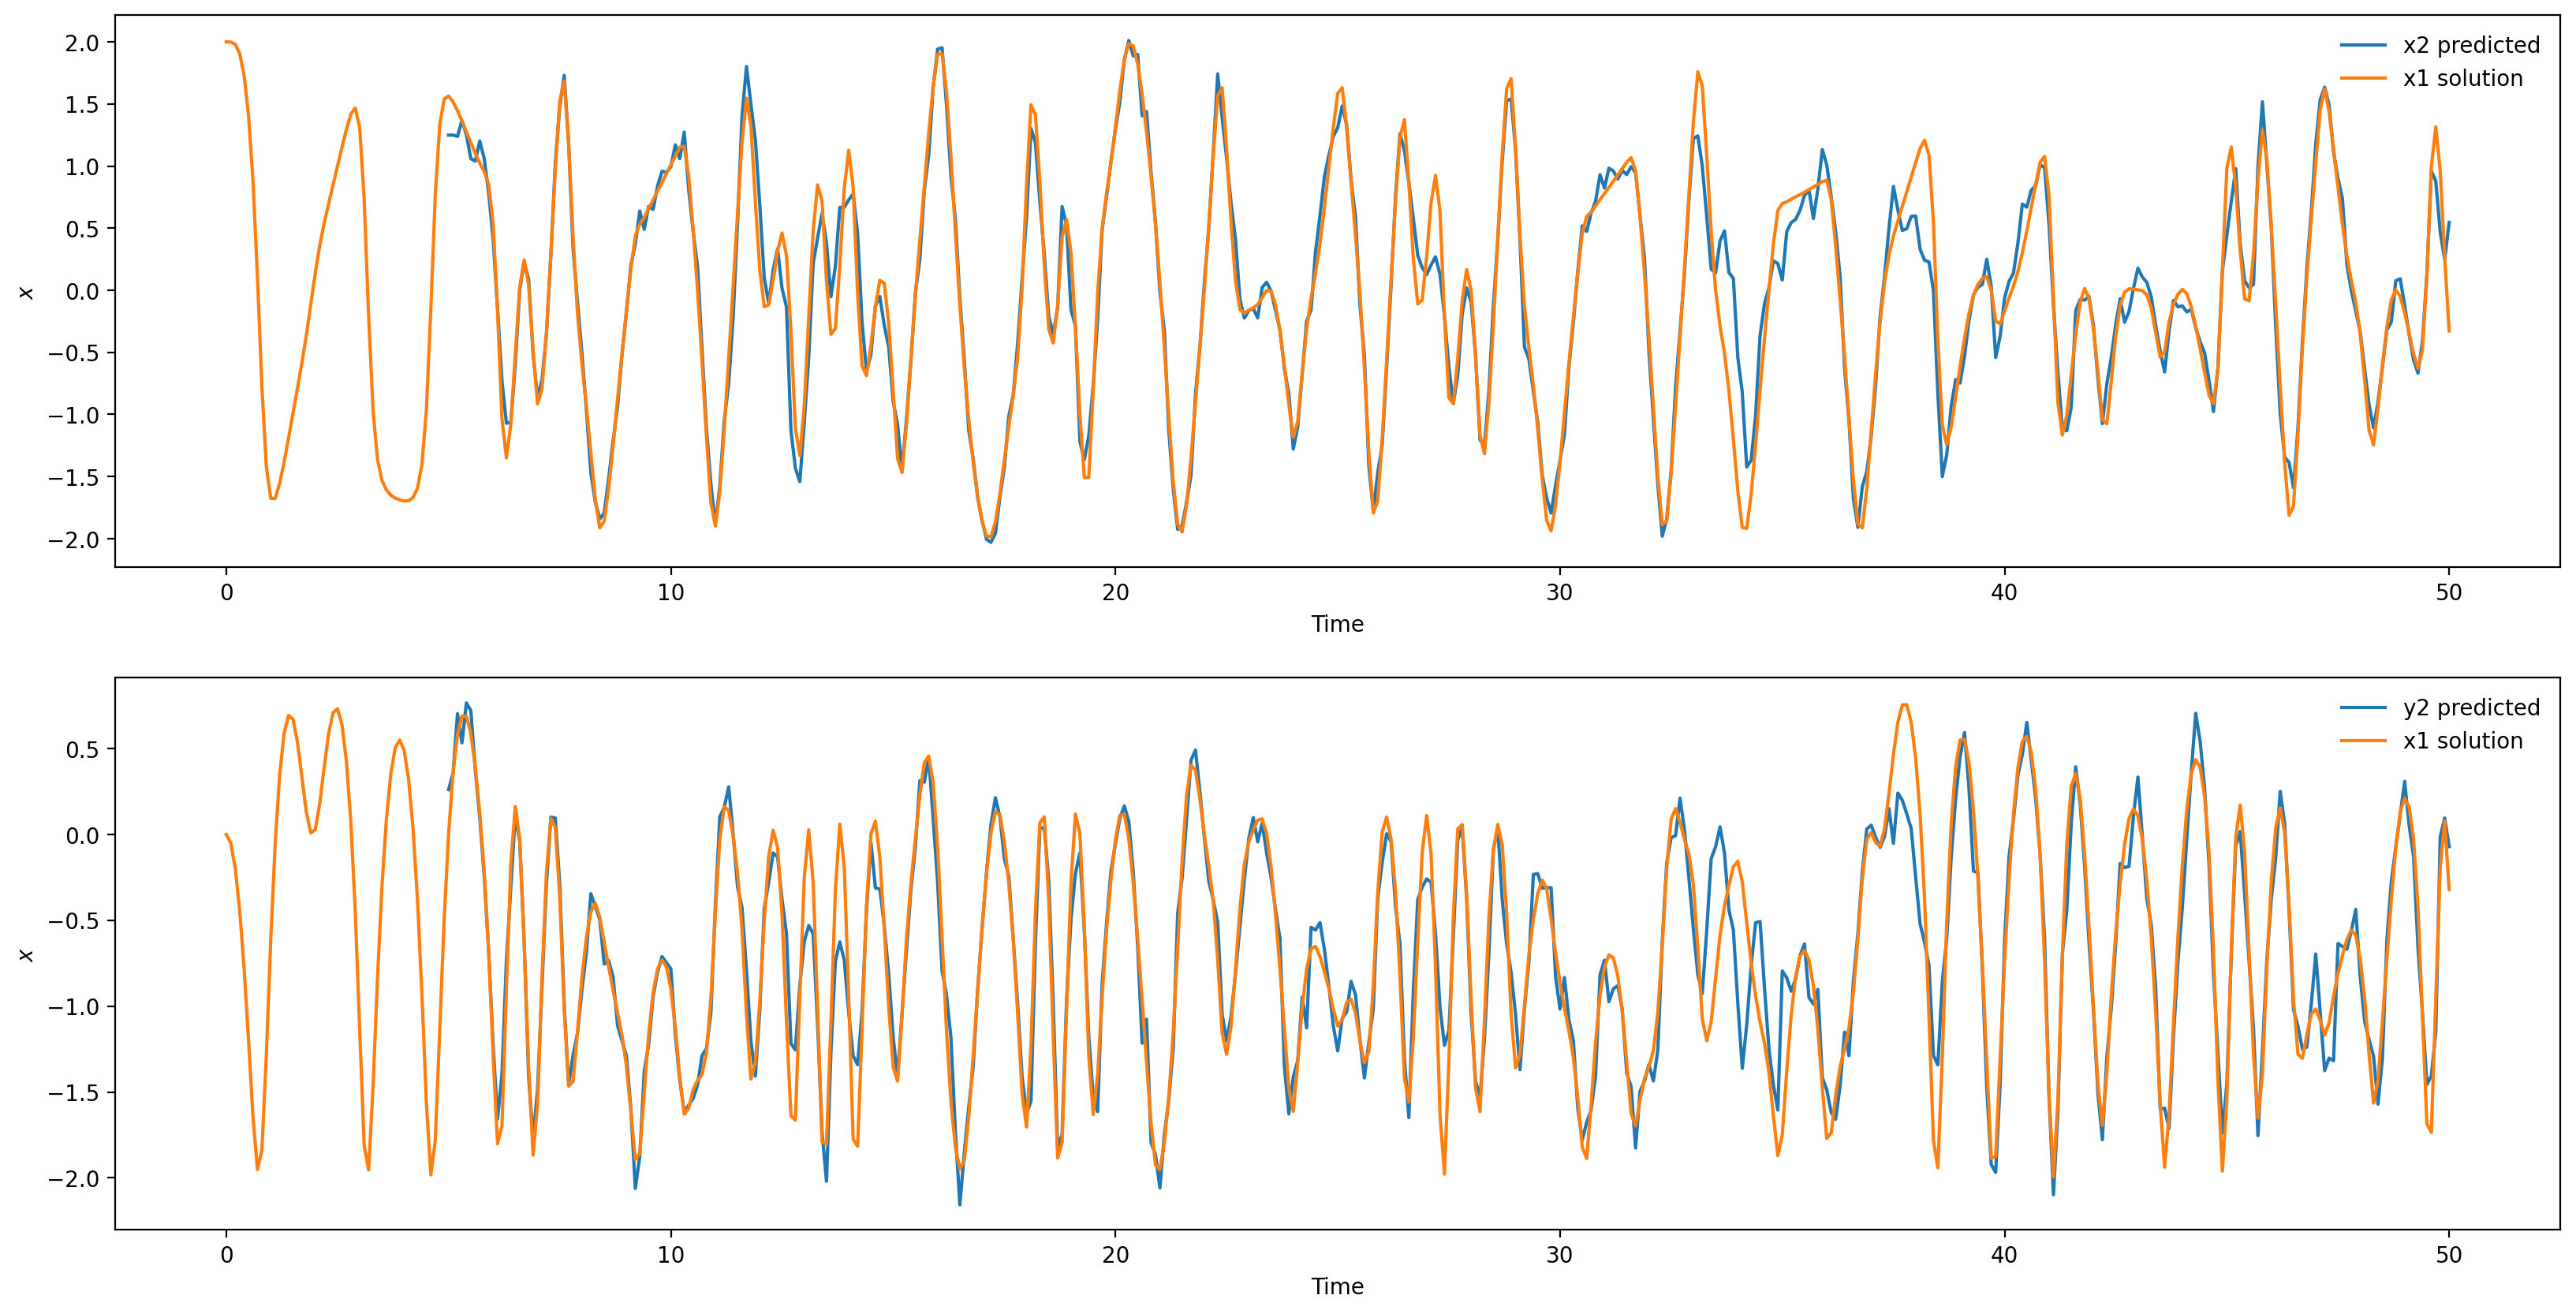

In [224]:
# mass 2
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(t[50:],train_predicted[:,2],label='x2 predicted')
ax[0].plot(t,x2,label='x1 solution')
ax[0].set_ylabel(r"$  x $")
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(t[50:],train_predicted[:,3],label='y2 predicted')
ax[1].plot(t,y2,label='x1 solution')
ax[1].set_ylabel(r"$  x $")
ax[1].set_xlabel("Time")
ax[1].legend()

## Task 4 - repeat task 3

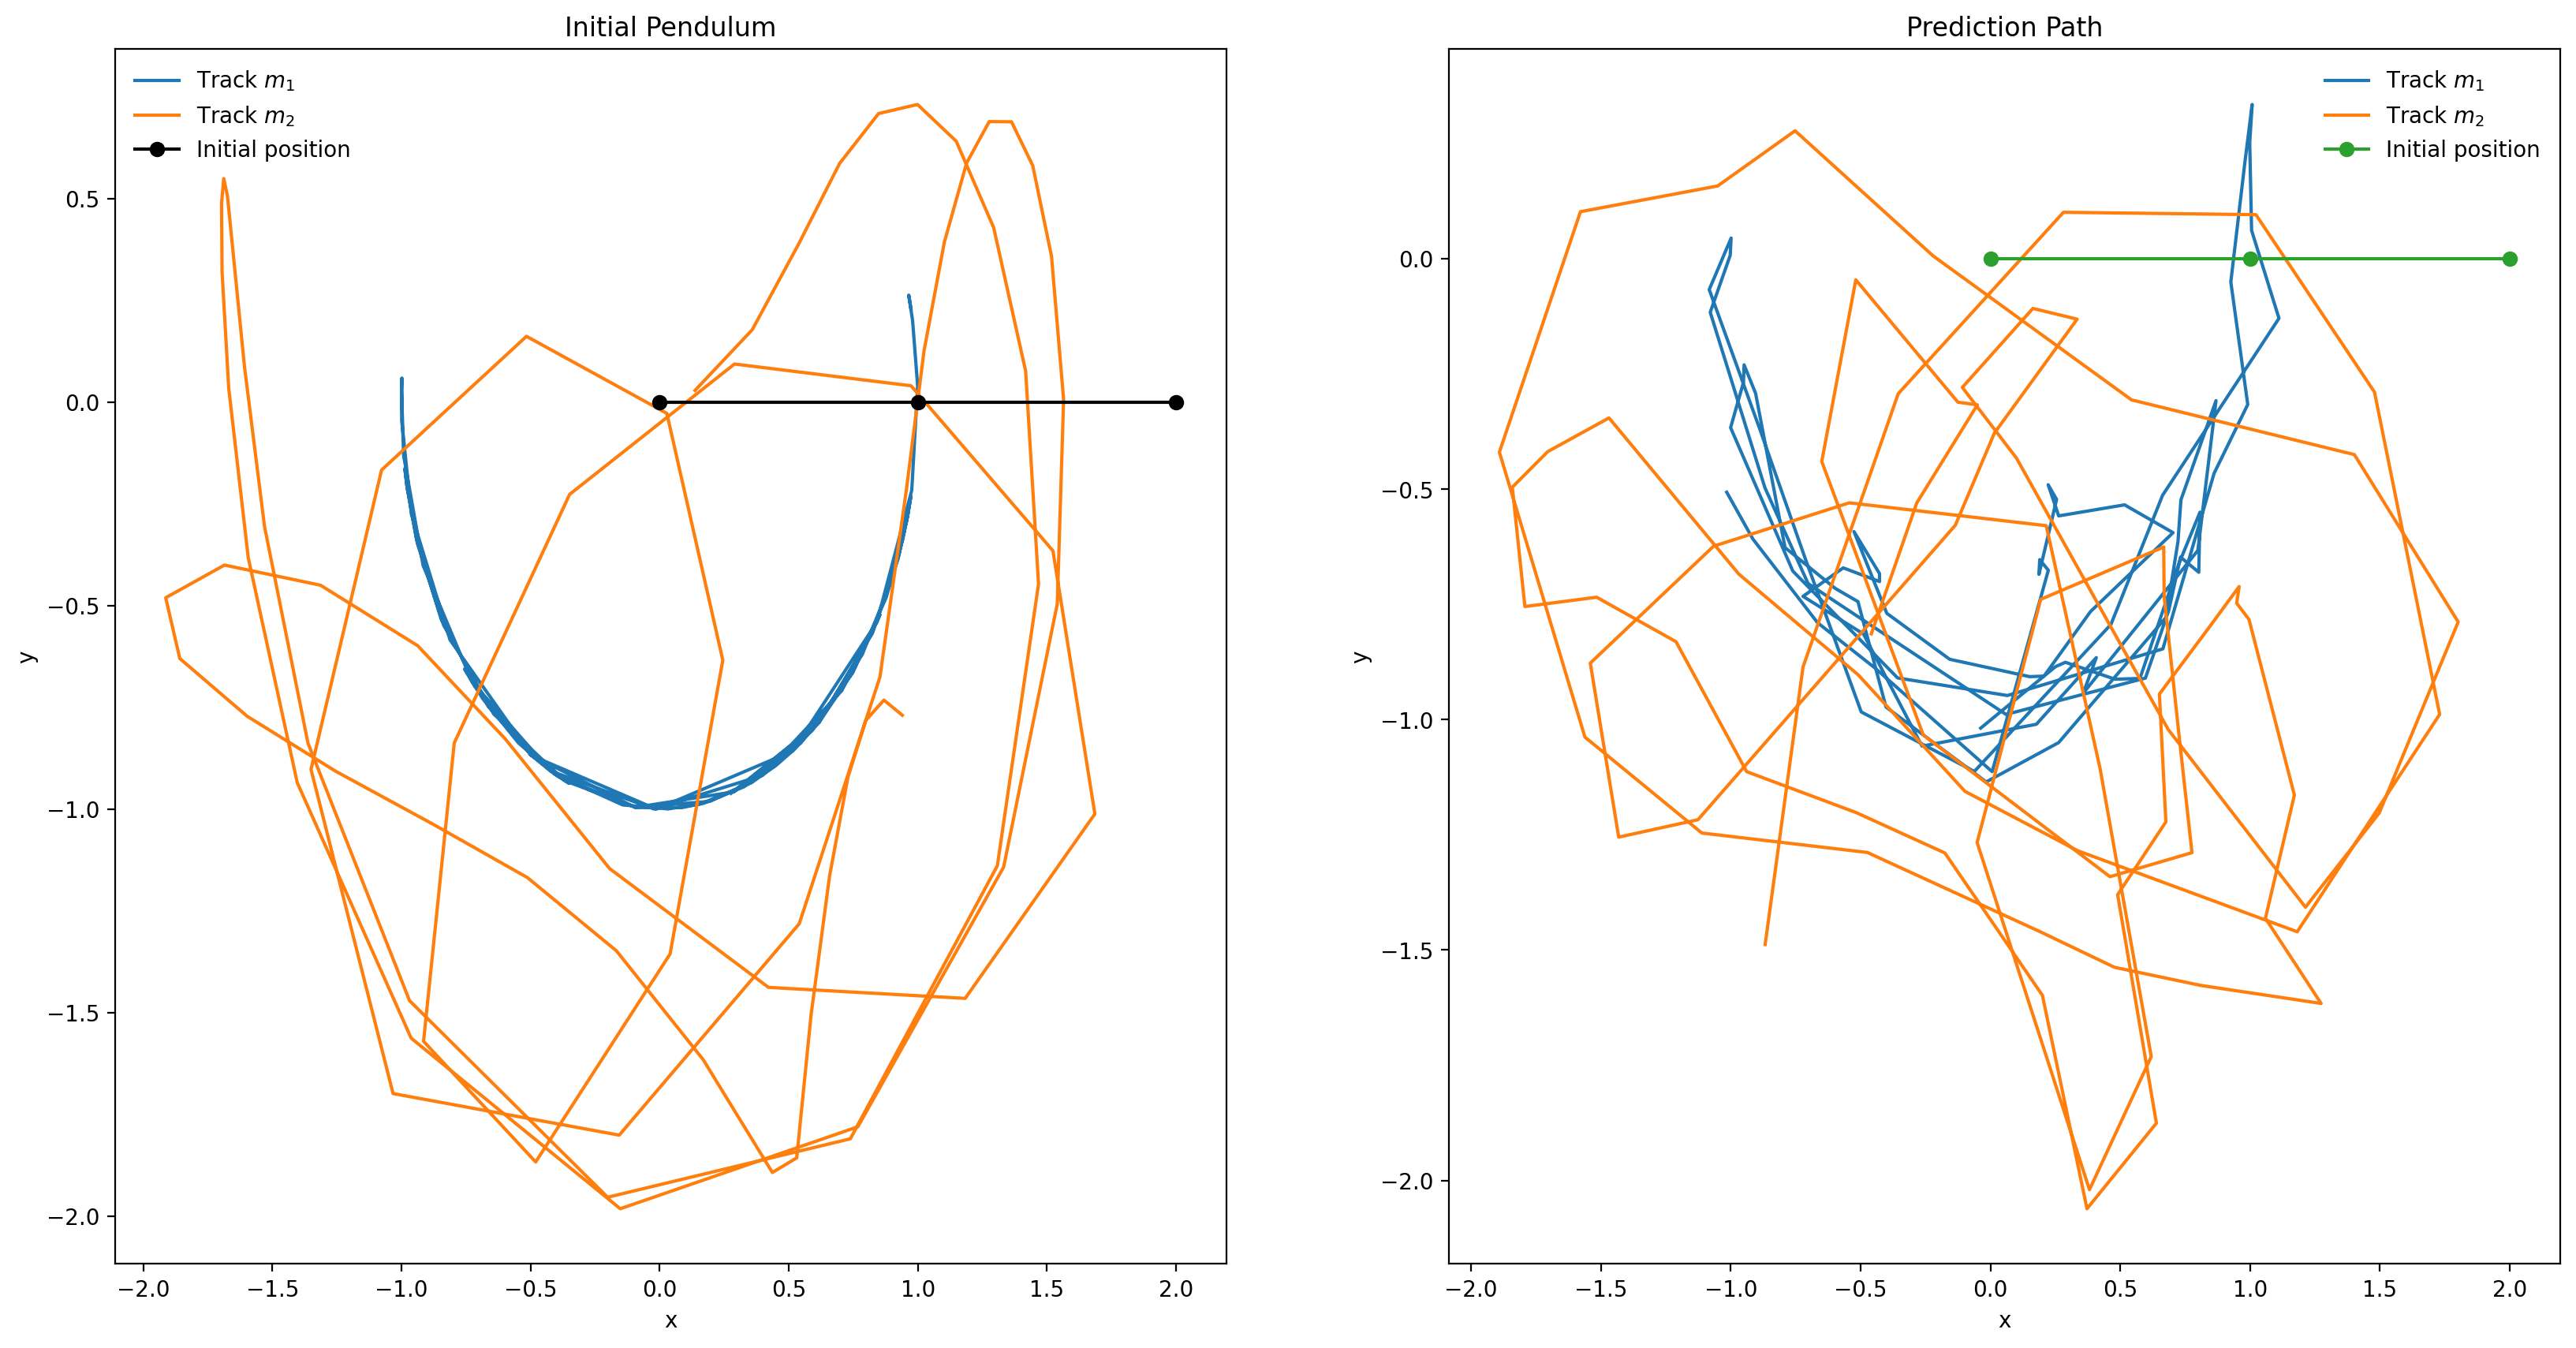

In [226]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
# Plot of original solution solve.ivp
ax[0].plot(x1[20:100], y1[20:100], label=r"Track $m_1$")
ax[0].plot(x2[20:100], y2[20:100], label=r"Track $m_2$")
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].set_title("Initial Pendulum")
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

# plot of predicted path
ax[1].plot(train_predicted[:,0][20:100], train_predicted[:,1][20:100], label=r"Track $m_1$")
ax[1].plot(train_predicted[:,2][20:100], train_predicted[:,3][20:100], label=r"Track $m_2$")
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position")
ax[1].set_title("Prediction Path")
ax[1].set_ylabel("y")
ax[1].set_xlabel("x")
ax[1].legend()

## Comment on the RNN prediction
The RNN prediction did really well overally to predict the non-linearity behaviour of the double pendulum.

## Task 5

# Task 5 repear 1

In [229]:
#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Define
model=keras.models.Sequential()
model.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=False))
model.add(keras.layers.Dense(2,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

from pathlib import WindowsPath
# we have previously worked out the cartesian solution
print("Shape of x1,y1,x2,y2 is",x1.shape, y1.shape,x2.shape,y2.shape)

# note that target = (Window size + offset - 1) and our target is 20
Windowsize=10
offset=11

# Training data



x2_train = x2[0:int(0.9*len(x2))]
y2_train = y2[0:int(0.9*len(y2))]



z_train=np.column_stack((x2_train,y2_train)).T


# shape array into window size and offset target
train_data, train_label = shapeArray2D(z_train,Windowsize,offset)


# Train the recurrent neural network using these cartesian solution to predict the 20th time step t=t_0 + 20 dt
steps=600


#storage for training parameters
train_cost=np.zeros(steps)

# define a function to train the recurrent neural network
def train_model(model, train_d,train_l,step,windowsize):

    train_cost=np.zeros(step)


    for j in tqdm(range(step)):

        # training our train_data
        train_data=train_d.reshape(train_d.shape[0],windowsize,2)
        train_label=train_l.reshape(train_l.shape[0],2)
        train_cost[j]=model.train_on_batch(train_data,train_label)



    # Prediction
    train_data_parameter = train_d.reshape(train_d.shape[0],windowsize,2)


    train_pre = model.predict_on_batch(train_data_parameter)


    return train_cost, train_pre
Cost, train_predict = train_model(model, train_data, train_label,steps,Windowsize)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, None, 50)          10600     
                                                                 
 lstm_35 (LSTM)              (None, 50)                20200     
                                                                 
 dense_25 (Dense)            (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of x1,y1,x2,y2 is (501,) (501,) (501,) (501,)


100%|██████████| 600/600 [00:45<00:00, 13.22it/s]


In [231]:
#Because we have set the window size and offset, the row element of train_predict is the 20th timestep


x2_p, y2_p= train_predict[0,:]

print("The future position of mass m2 is", (x2_p,y2_p))

# we can compare this to the original solution via solve_ivp

print("Data position for mass m2 is",(x2[20],y2[20]))


The future position of mass m2 is (0.1360172, 0.029146621)
Data position for mass m2 is (0.13710703120212095, 0.029171597015900663)


## Comment
The accuracy is around 2d.p

## Task 5 Repeating Task 2

In [232]:
model2=keras.models.Sequential()

model2.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=True)) # LSTM layer with 50 neurons
model2.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=False))
model2.add(keras.layers.Dense(2,activation='linear'))

model2.compile(loss='mean_squared_error',optimizer='adam')

model2.summary()
# Train Array

x2_train = x2[0:int(1*len(x2))]
y2_train = y2[0:int(1*len(y2))]

# Create Data Storage for Train data and Test data

z_train = np.column_stack(( x2_train, y2_train)).T

def shapearray(dataset, windowsize, offset):

    data,label=[],[]
    #loop over entire dataset
    for i in range(windowsize,len(dataset[0])-offset):
        #extract an item(input) of size (windowsize) of elements from i-windowsize to i
        item=dataset[:,(i-windowsize):i]

        #append item to corresponding lists
        data.append(item)
        label.append(dataset[:,i+offset])
    #turn lists into arrays
    data, label = np.array(data), np.array(label)
    return data, label

# Parameters
steps = 1000
windowsize = 30
offset = 20

# Data
train_data, train_label = shapearray(z_train, windowsize, offset)


def train_cost_pred_model(model, train_data, train_label, steps, windowsize):
    # Storage of training and testing data
    train_cost = np.zeros(steps)


    for i in tqdm(range(steps)):
        # Reshape input and labels for training data
        train_data_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])
        train_label_reshaped = train_label.reshape(train_label.shape[0], train_label.shape[1])
        train_cost[i] = model.train_on_batch(train_data_reshaped, train_label_reshaped)



    # Reshape input for prediction
    train_input_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])

    train_predict = model2.predict_on_batch(train_input_reshaped)


    return train_cost, train_predict

train_cost1 , train_predicted = train_cost_pred_model(model2,train_data,train_label,steps,windowsize)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, None, 50)          10600     
                                                                 
 lstm_37 (LSTM)              (None, 50)                20200     
                                                                 
 dense_26 (Dense)            (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


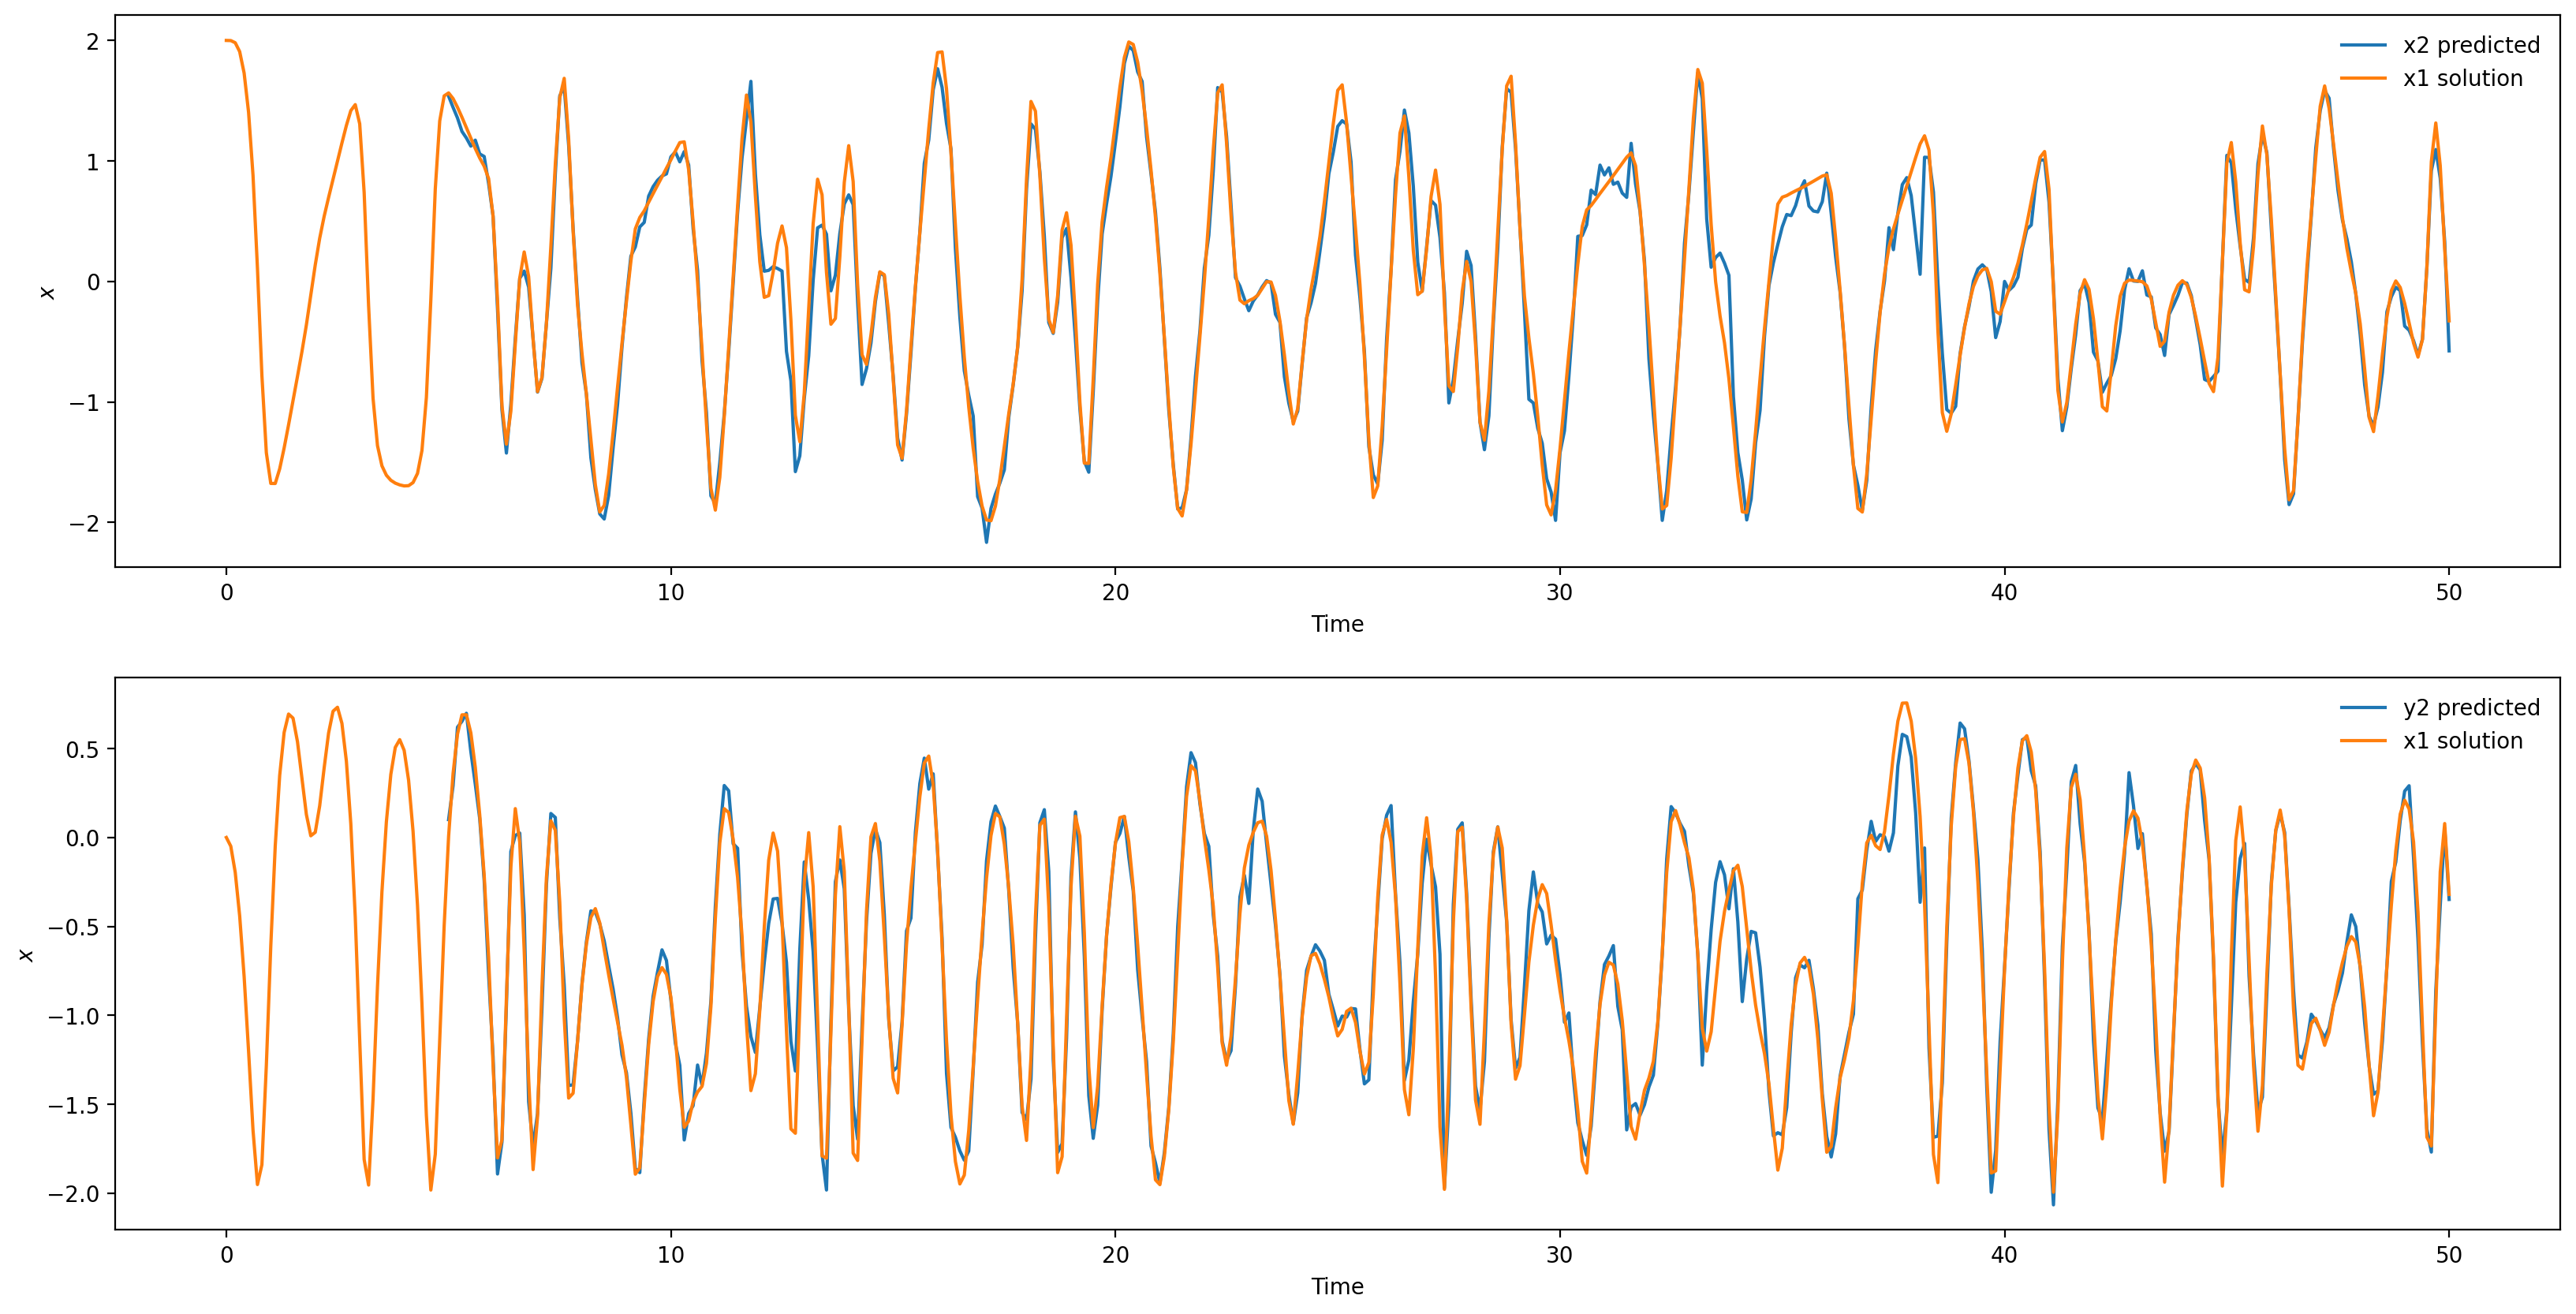

In [234]:
# mass 2
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(t[50:],train_predicted[:,0],label='x2 predicted')
ax[0].plot(t,x2,label='x1 solution')
ax[0].set_ylabel(r"$  x $")
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(t[50:],train_predicted[:,1],label='y2 predicted')
ax[1].plot(t,y2,label='x1 solution')
ax[1].set_ylabel(r"$  x $")
ax[1].set_xlabel("Time")
ax[1].legend()

## Task 5 repeating Task 3

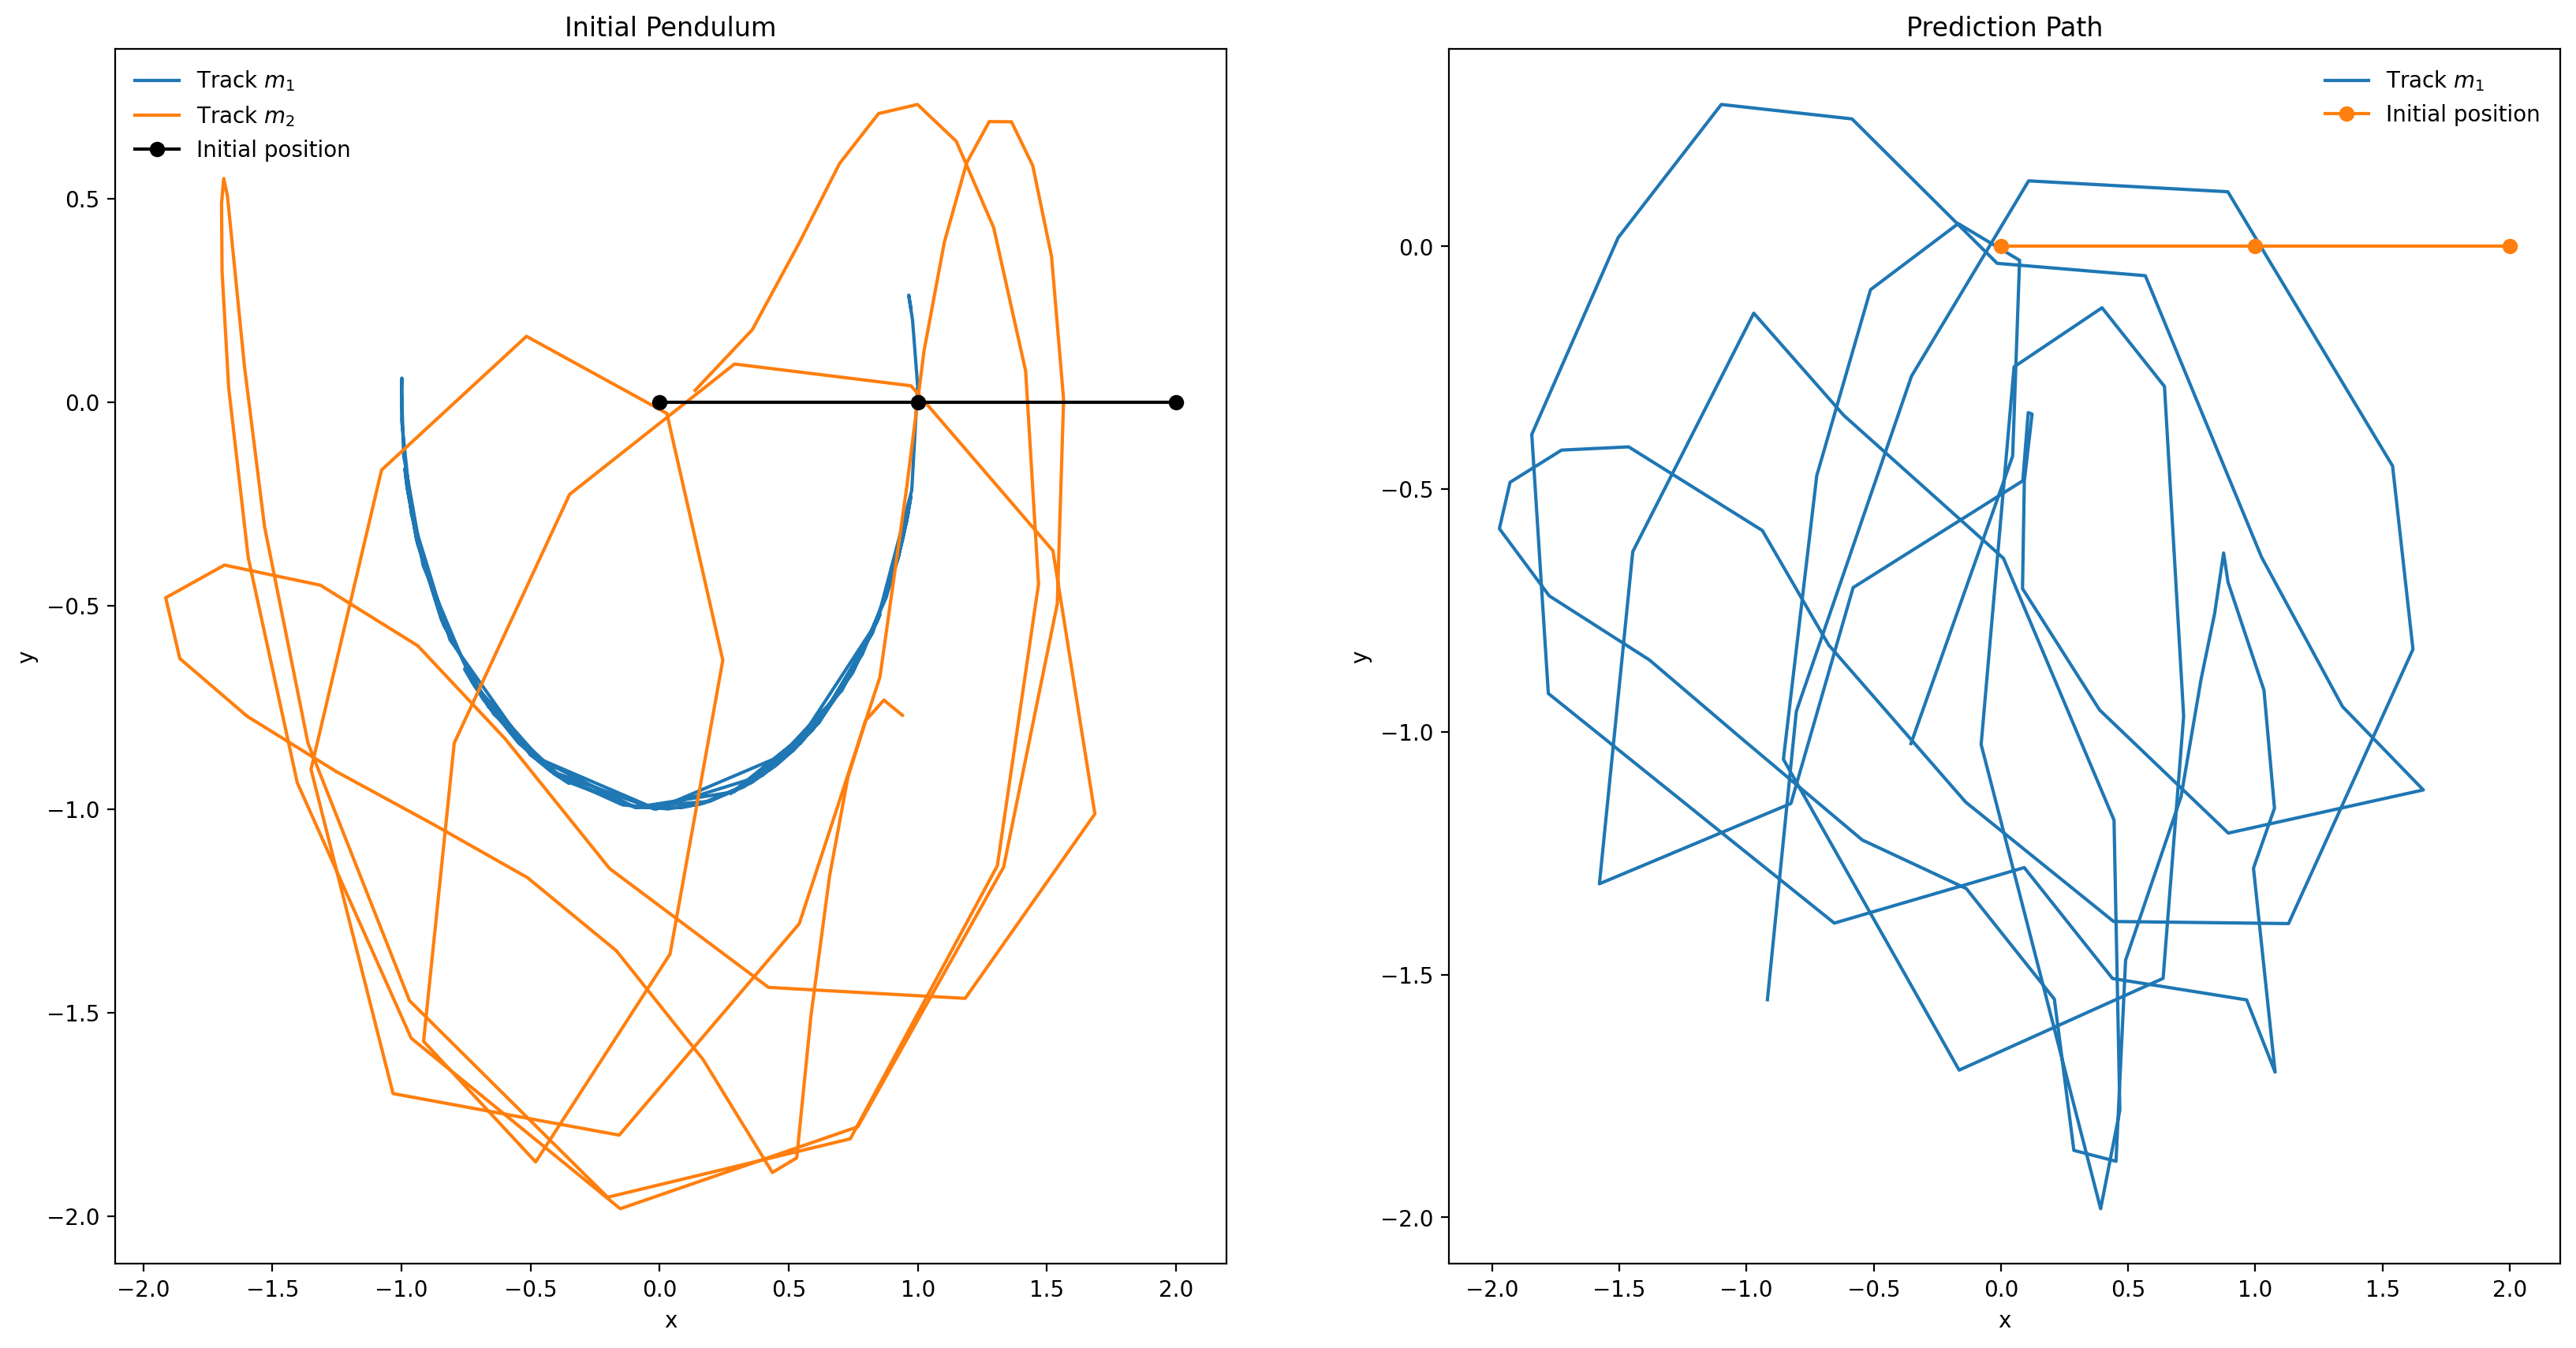

In [236]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
# Plot of original solution solve.ivp
ax[0].plot(x1[20:100], y1[20:100], label=r"Track $m_1$")
ax[0].plot(x2[20:100], y2[20:100], label=r"Track $m_2$")
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].set_title("Initial Pendulum")
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

# plot of predicted path
ax[1].plot(train_predicted[:,0][20:100], train_predicted[:,1][20:100], label=r"Track $m_1$")

ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position")
ax[1].set_title("Prediction Path")
ax[1].set_ylabel("y")
ax[1].set_xlabel("x")
ax[1].legend()

## Task 5 Repeating Task 4

In [237]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


## Task 5 Repeating Task 4 Repeating Task 1

In [238]:
#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Define
model=keras.models.Sequential()
model.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=False))
model.add(keras.layers.Dense(2,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

from pathlib import WindowsPath
# we have previously worked out the cartesian solution
print("Shape of x1,y1,x2,y2 is",x1.shape, y1.shape,x2.shape,y2.shape)

# note that target = (Window size + offset - 1) and our target is 20
Windowsize=10
offset=11

# Training data



x2_train = x2[0:int(0.9*len(x2))]
y2_train = y2[0:int(0.9*len(y2))]



z_train=np.column_stack((x2_train,y2_train)).T


# shape array into window size and offset target
train_data, train_label = shapeArray2D(z_train,Windowsize,offset)


# Train the recurrent neural network using these cartesian solution to predict the 20th time step t=t_0 + 20 dt
steps=600


#storage for training parameters
train_cost=np.zeros(steps)

# define a function to train the recurrent neural network
def train_model(model, train_d,train_l,step,windowsize):

    train_cost=np.zeros(step)


    for j in tqdm(range(step)):

        # training our train_data
        train_data=train_d.reshape(train_d.shape[0],windowsize,2)
        train_label=train_l.reshape(train_l.shape[0],2)
        train_cost[j]=model.train_on_batch(train_data,train_label)



    # Prediction
    train_data_parameter = train_d.reshape(train_d.shape[0],windowsize,2)


    train_pre = model.predict_on_batch(train_data_parameter)


    return train_cost, train_pre
Cost, train_predict = train_model(model, train_data, train_label,steps,Windowsize)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, None, 50)          10600     
                                                                 
 lstm_39 (LSTM)              (None, 50)                20200     
                                                                 
 dense_27 (Dense)            (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Shape of x1,y1,x2,y2 is (501,) (501,) (501,) (501,)


100%|██████████| 600/600 [00:50<00:00, 11.96it/s]


In [239]:
#Because we have set the window size and offset, the row element of train_predict is the 20th timestep


x2_p, y2_p= train_predict[0,:]

print("The future position of mass m2 is", (x2_p,y2_p))

# we can compare this to the original solution via solve_ivp

print("Data position for mass m2 is",(x2[20],y2[20]))


The future position of mass m2 is (0.32894215, -1.9549482)
Data position for mass m2 is (0.32885641537207594, -1.955113608454076)


## Task 5 Repeating Task 4 repeating Task 2

In [240]:
model2=keras.models.Sequential()

model2.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=True)) # LSTM layer with 50 neurons
model2.add(keras.layers.LSTM(50,input_shape=(None,2),return_sequences=False))
model2.add(keras.layers.Dense(2,activation='linear'))

model2.compile(loss='mean_squared_error',optimizer='adam')

model2.summary()
# Train Array

x2_train = x2[0:int(1*len(x2))]
y2_train = y2[0:int(1*len(y2))]

# Create Data Storage for Train data and Test data

z_train = np.column_stack(( x2_train, y2_train)).T

def shapearray(dataset, windowsize, offset):

    data,label=[],[]
    #loop over entire dataset
    for i in range(windowsize,len(dataset[0])-offset):
        #extract an item(input) of size (windowsize) of elements from i-windowsize to i
        item=dataset[:,(i-windowsize):i]

        #append item to corresponding lists
        data.append(item)
        label.append(dataset[:,i+offset])
    #turn lists into arrays
    data, label = np.array(data), np.array(label)
    return data, label

# Parameters
steps = 1000
windowsize = 30
offset = 20

# Data
train_data, train_label = shapearray(z_train, windowsize, offset)


def train_cost_pred_model(model, train_data, train_label, steps, windowsize):
    # Storage of training and testing data
    train_cost = np.zeros(steps)


    for i in tqdm(range(steps)):
        # Reshape input and labels for training data
        train_data_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])
        train_label_reshaped = train_label.reshape(train_label.shape[0], train_label.shape[1])
        train_cost[i] = model.train_on_batch(train_data_reshaped, train_label_reshaped)



    # Reshape input for prediction
    train_input_reshaped = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])

    train_predict = model2.predict_on_batch(train_input_reshaped)


    return train_cost, train_predict

train_cost1 , train_predicted = train_cost_pred_model(model2,train_data,train_label,steps,windowsize)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, None, 50)          10600     
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dense_28 (Dense)            (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


100%|██████████| 1000/1000 [02:41<00:00,  6.17it/s]


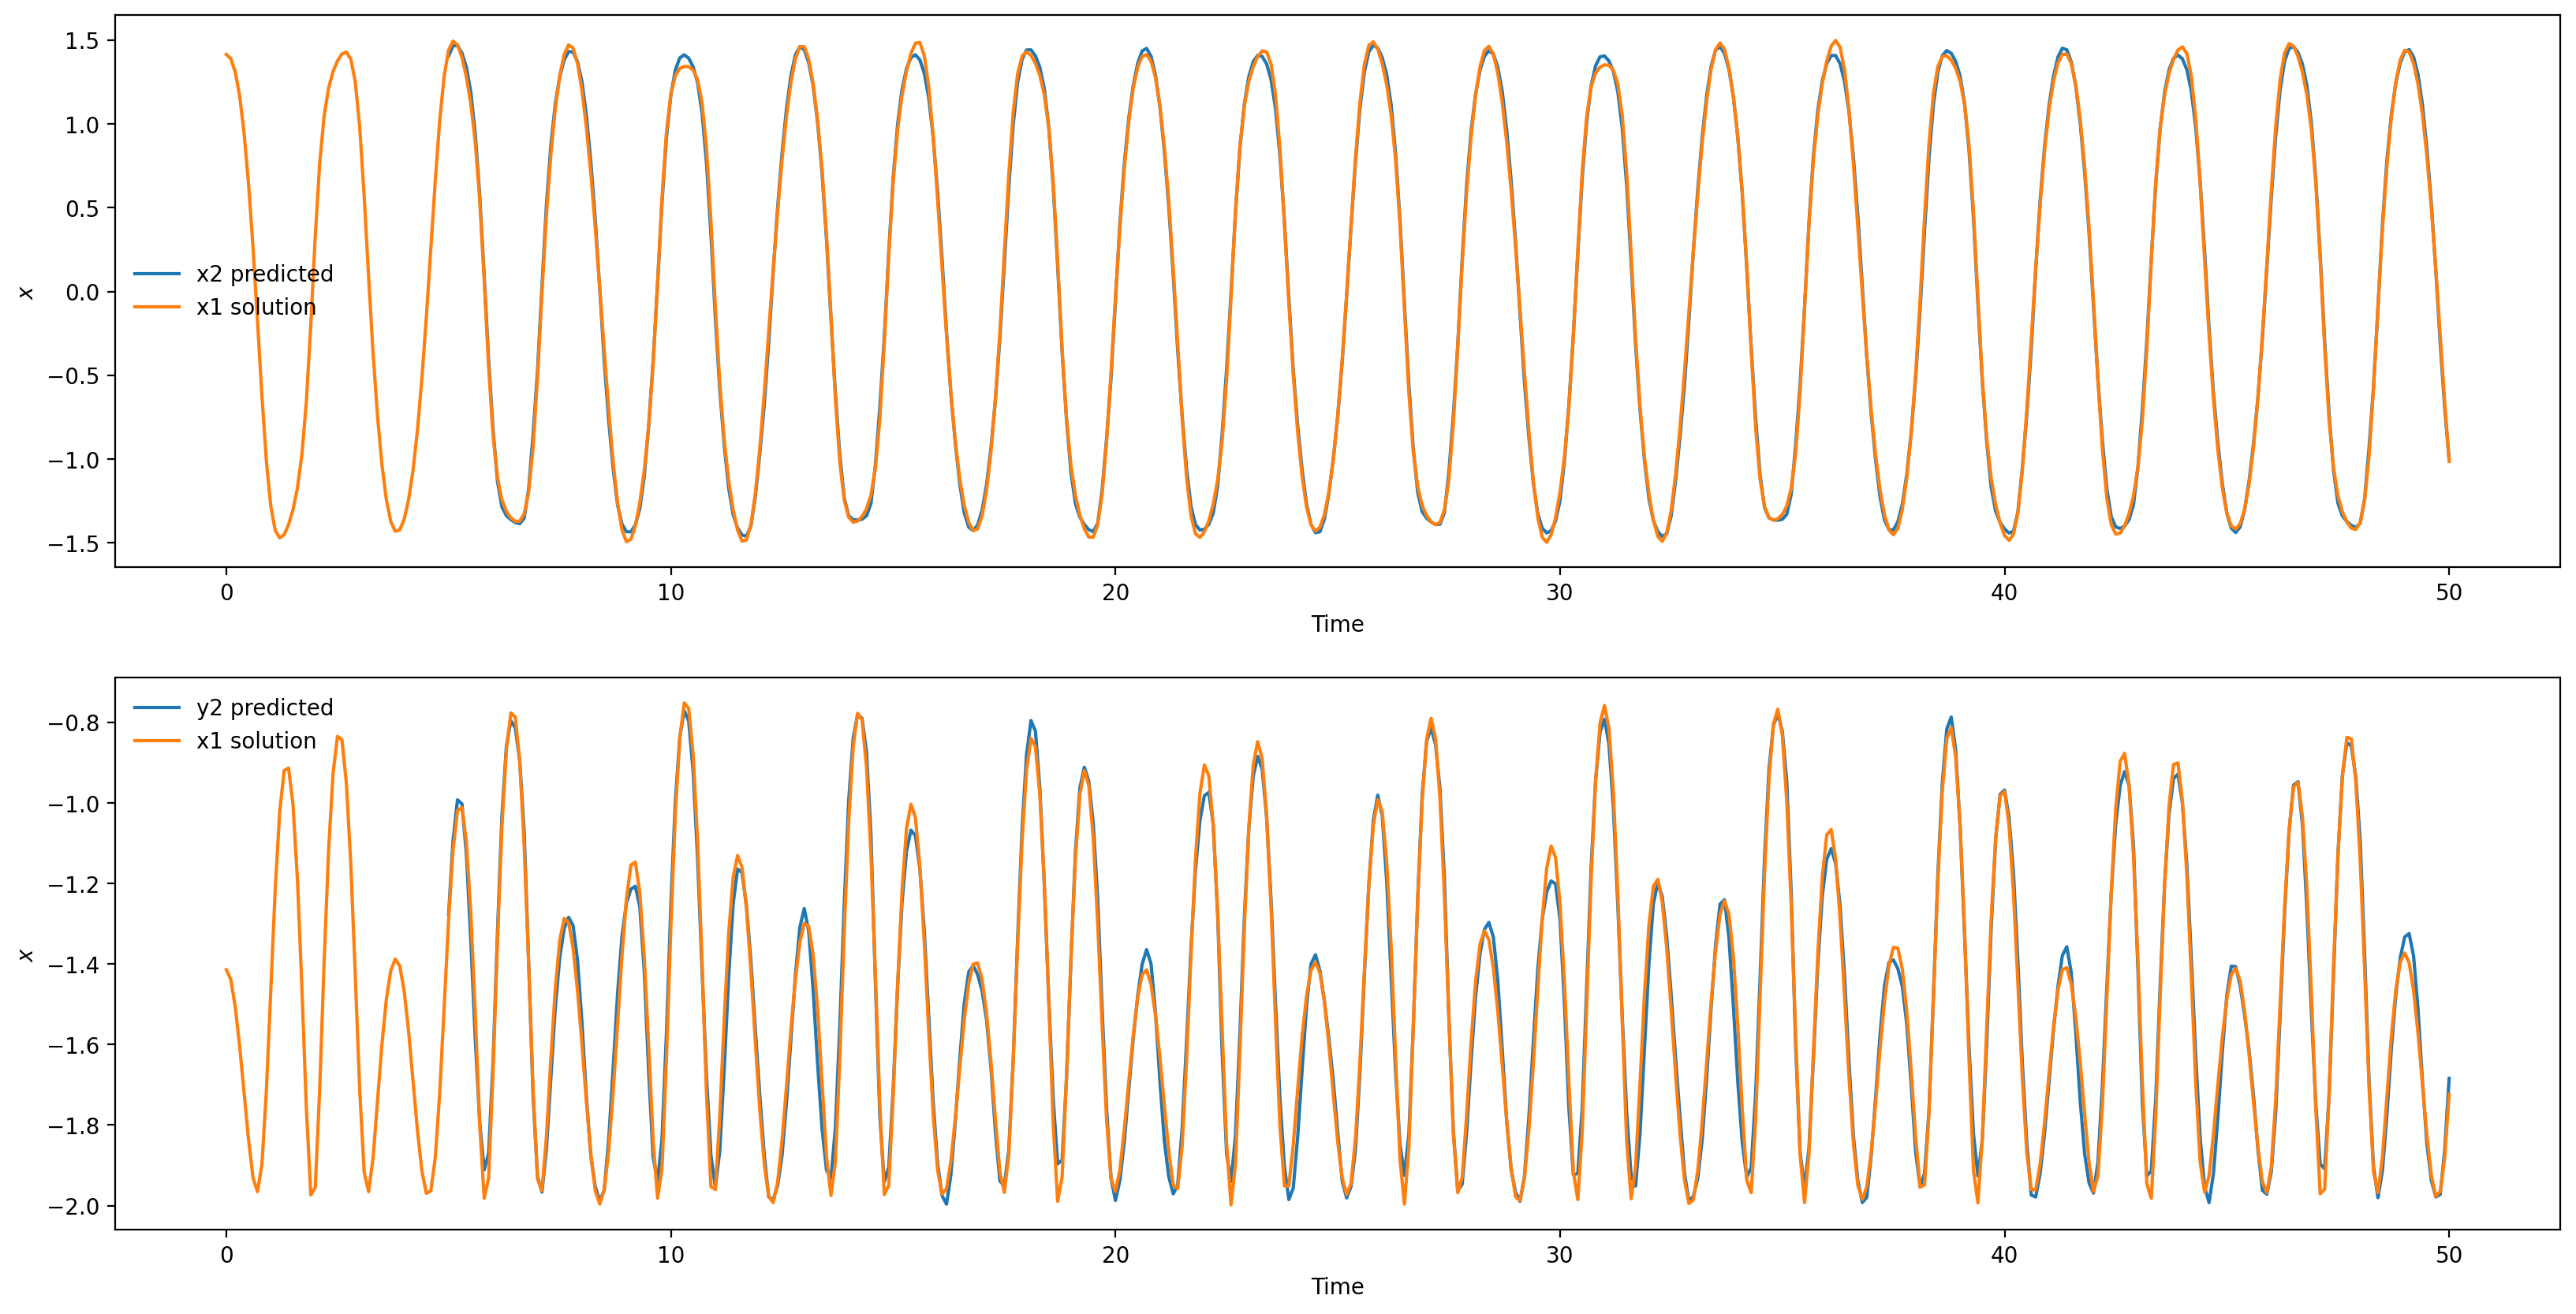

In [241]:
# mass 2
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(t[50:],train_predicted[:,0],label='x2 predicted')
ax[0].plot(t,x2,label='x1 solution')
ax[0].set_ylabel(r"$  x $")
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot(t[50:],train_predicted[:,1],label='y2 predicted')
ax[1].plot(t,y2,label='x1 solution')
ax[1].set_ylabel(r"$  x $")
ax[1].set_xlabel("Time")
ax[1].legend()

## Task 5 repeating Task 4 repeating Task 3

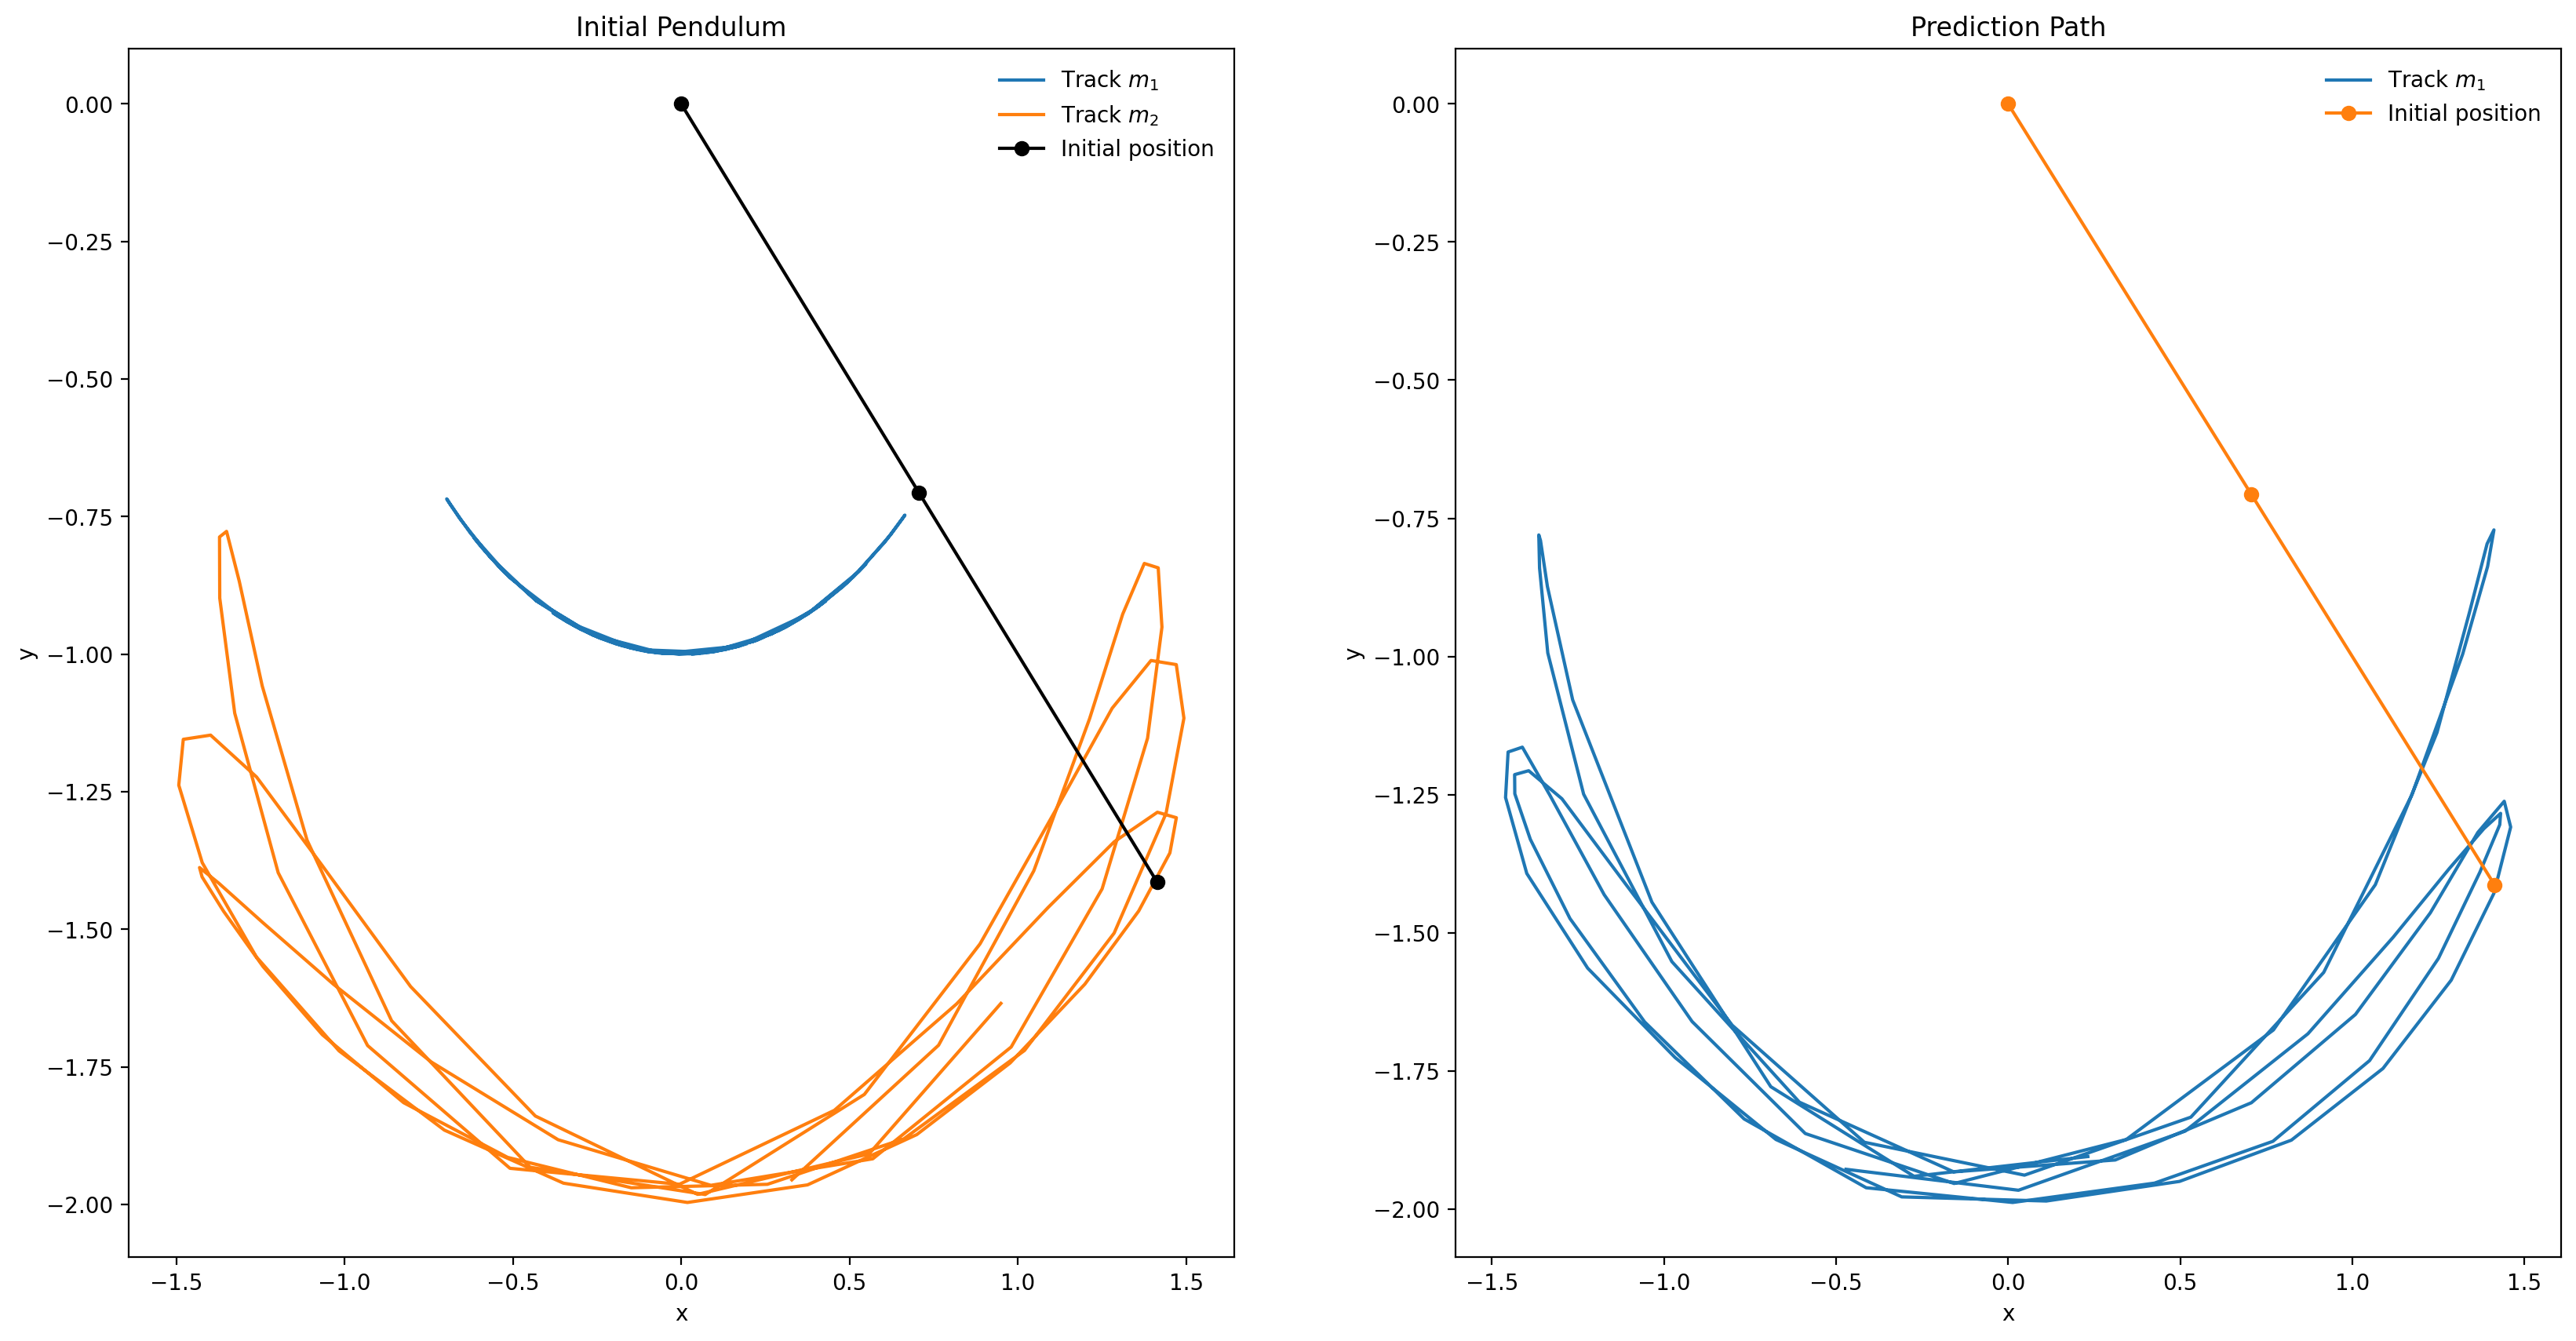

In [242]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
# Plot of original solution solve.ivp
ax[0].plot(x1[20:100], y1[20:100], label=r"Track $m_1$")
ax[0].plot(x2[20:100], y2[20:100], label=r"Track $m_2$")
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].set_title("Initial Pendulum")
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")
ax[0].legend()

# plot of predicted path
ax[1].plot(train_predicted[:,0][20:100], train_predicted[:,1][20:100], label=r"Track $m_1$")

ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position")
ax[1].set_title("Prediction Path")
ax[1].set_ylabel("y")
ax[1].set_xlabel("x")
ax[1].legend()

## Comment
The prediction is pretty good even without mass 1